### Generative model, and sampling from it

We start by creating an instance of our prior and likelihood models.

In [1]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro


import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [2]:
#import data

import matplotlib.pyplot as plt
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



670752


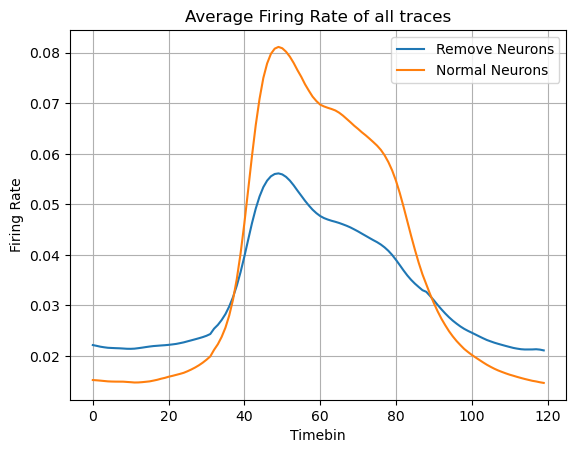

In [3]:
remove_mean = np.zeros((14,120))
normal_mean = np.zeros((14,120))
for i in range(14):
    remove_mean[i,:] = np.nanmean(resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,i)[:,4,:,:,:],axis = (0,1,2))
    normal_mean[i,:] = np.nanmean(remove_neurons(SATED_DECONV,SATED_ANGLE,SATED_SF,i)[:,4,:,:,:],axis = (0,1,2))
plt.plot(np.mean(remove_mean,axis=0), label = 'Remove Neurons')
plt.plot(np.mean(normal_mean,axis=0), label = 'Normal Neurons')
plt.xlabel('Timebin')
plt.ylabel('Firing Rate')
plt.title('Average Firing Rate of all traces')
plt.legend()
plt.grid()

In [5]:
TEST_DATA = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)[:,:,0,:,40:80]
# Animal = 0, SF = 0 and during response
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
print(TEST_RESPONSE.shape)
N = TEST_RESPONSE.shape[2]
C = TEST_RESPONSE.shape[1]
K = TEST_RESPONSE.shape[0]
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

# keep only trials that have at least one finite value
good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K = TEST_RESPONSE.shape[0]
print(f"{K} good trials remain")


# Z-score test response along the trial axis
# TEST_RESPONSE = (TEST_RESPONSE - jnp.nanmean(TEST_RESPONSE, axis=0)) / jnp.nanstd(TEST_RESPONSE, axis=0)


(11, 12, 137)
10 good trials remain


/tmp/ipykernel_610170/82705658.py:19: RuntimeWarning: Mean of empty slice
  TEST_RESPONSE = np.nanmean(best_test, axis=-1)  # Shape N x C x K


(11, 12, 113)
0
(11, 12, 137)
0


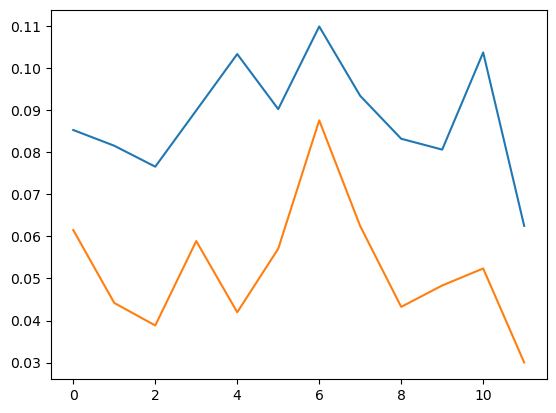

: 

In [ ]:
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
AngStim_data = '../Data/metadata_deconv/stimAngle_sated.mat'
ANG_STIM_DATA = loadmat(AngStim_data, simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SfStim_data = '../Data/metadata_deconv/stimSpatFreq_sated.mat'
SF_STIM_DATA = loadmat(SfStim_data, simplify_cells=True)
SATED_SF = SF_STIM_DATA['stimSpatFreq_arossAnimals']

TEST_DATA = resort_preprocessing(SATED_DECONV, SATED_ANGLE, SATED_SF, 0)[:, :, :, :, 40:80]

best_test = np.zeros((TEST_DATA.shape[0], TEST_DATA.shape[1], TEST_DATA.shape[3], TEST_DATA.shape[4]))
for i in range(TEST_DATA.shape[0]):
    best_sf = np.nanargmax(np.nanmean(TEST_DATA[i, :, :, :, :], axis=(0, 2, 3))).astype('int')
    best_test[i, :, :, :] = TEST_DATA[i, :, best_sf, :, :]




TEST_RESPONSE = np.nanmean(best_test, axis=-1)  # Shape N x C x K
good_trials = ~jnp.isnan(TEST_RESPONSE).any(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K = TEST_RESPONSE.shape[0]
y_full = jnp.transpose(TEST_RESPONSE, (2, 1, 0))
print(y_full.shape)
plt.plot(np.nanmean(y_full, axis = (0,2)))
print(np.sum(np.isnan(y_full)))


SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']


TEST_DATA = resort_preprocessing(SATED_DECONV, SATED_ANGLE, SATED_SF, 0)[:, :, 2, :, 40:80]
TEST_RESPONSE = np.nanmean(TEST_DATA, axis=-1)  # Shape N x C x K
good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K = TEST_RESPONSE.shape[0]
y_full = jnp.transpose(TEST_RESPONSE, (2, 1, 0))
print(y_full.shape)
plt.plot(np.nanmean(y_full, axis = (0,2)))
print(np.sum(np.isnan(y_full)))



In [11]:
import pandas as pd

# Load the CSV file and print its contents
df = pd.read_csv("random_search_summary.csv")
print(df)

   group  animal    N  period       best_ll  P    l_wp_a    b_wp_a
0     FR       1  162      12 -1.000000e+30  8  3.412613  0.737047
1     FR       2  106      12 -1.000000e+30  8  3.412613  0.737047
2     FR       3  114      12 -1.000000e+30  8  3.412613  0.737047
3     FR       6  136      12 -1.000000e+30  8  3.412613  0.737047
4     FR       7  104      12 -1.000000e+30  8  3.412613  0.737047
5     FR       8  109      12 -1.000000e+30  8  3.412613  0.737047
6     FR      11  235      12 -1.000000e+30  8  3.412613  0.737047
7     FR      12  129      12 -1.000000e+30  8  3.412613  0.737047
8    CTR       0  137      12 -1.000000e+30  8  3.412613  0.737047
9    CTR       4  112      12 -1.000000e+30  8  3.412613  0.737047
10   CTR       5   56      12 -1.000000e+30  8  3.412613  0.737047
11   CTR       9   94      12 -1.000000e+30  8  3.412613  0.737047
12   CTR      10  104      12 -1.000000e+30  8  3.412613  0.737047
13   CTR      13  134      12 -1.000000e+30  8  3.412613  0.73

In [6]:
hyperparams = {
    'sigma_m':2.4886496,
    'gamma_gp': 0.00016234,
    'beta_gp': 0.24385944,
    'sigma_c': 0.28382865,
    'gamma_wp':0.00044405,
    'beta_wp':1.0398238,
    'p': 0,
}

In [7]:
# Initialise Kernel and Model
periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['sigma_m']))
periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['sigma_c']))

In [8]:

# Prior distribution (GP and WP)
gp = models.GaussianProcess(kernel=periodic_kernel_gp,N=N)
# wp = models.WishartProcess(kernel =periodic_kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
wp = models.WishartLRDProcess(kernel=periodic_kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
likelihood = models.NormalConditionalLikelihood(N)

Now we are ready to fit the model to data and infer posterior distributions over neural means and covariances. Then we can sample from the inferred posterior and compute their likelihoods.

In [9]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
inference_seed = 2
varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key = jax.random.PRNGKey(inference_seed)

varfam.infer(adam,X_CONDITIONS,TEST_RESPONSE,n_iter = 6000,key=key)
joint.update_params(varfam.posterior)
posterior = models.NormalGaussianWishartPosterior(joint, varfam, X_CONDITIONS)

/home/scastedo/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/6000 [00:00<?, ?it/s]/home/scastedo/miniforge3/envs/wishart/lib/python3.13/site-packages/jax/_src/linear_util.py:370: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = _fun(*args, **kwargs)
100%|██████████| 6000/6000 [00:23<00:00, 257.03it/s, init loss: 28377043.4027, avg. loss [5701-6000]: -14945.3963]


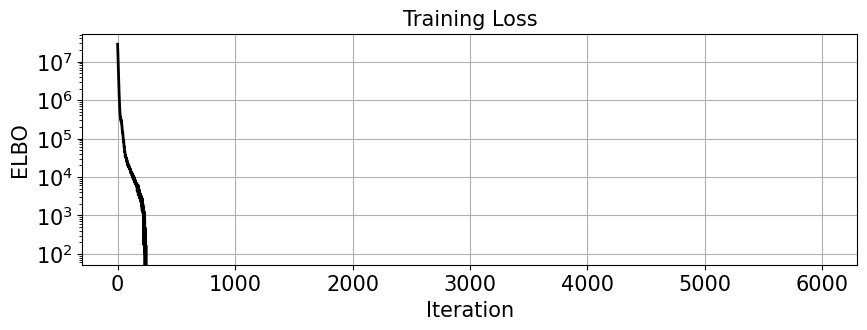

In [10]:
# %% Visualization
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

We can sample from the inferred posterior, compute likelihoods and summary statistics, evaluate its mode, compute derivatives, and more.

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


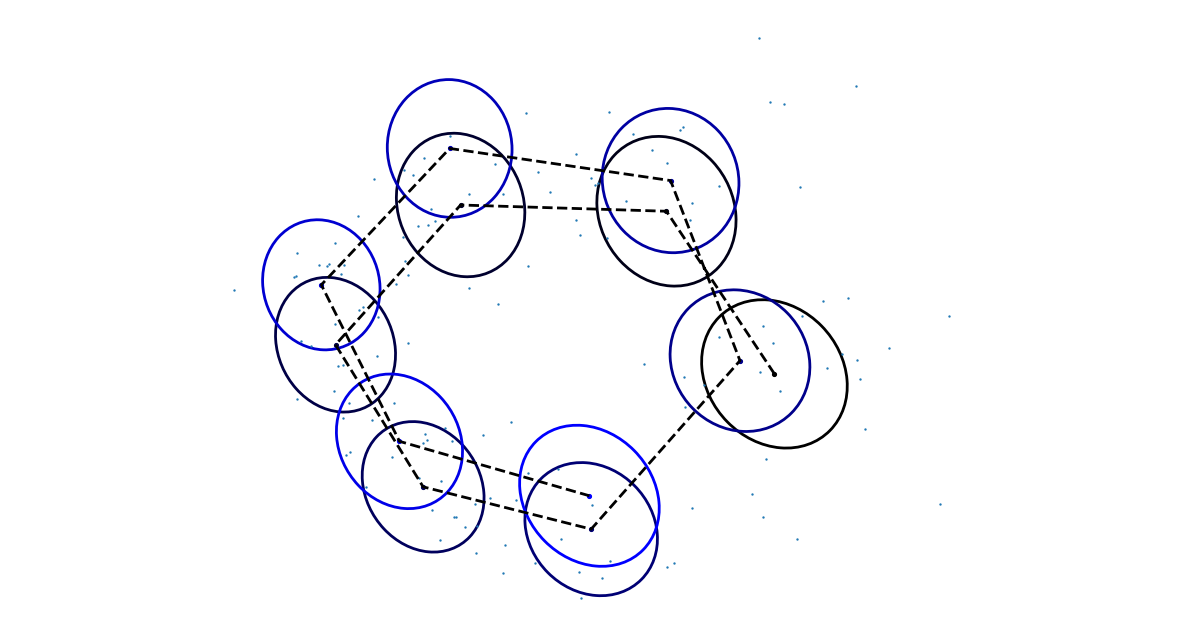

In [11]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,X_CONDITIONS)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


1.2737515224597837 0.04521401264131749


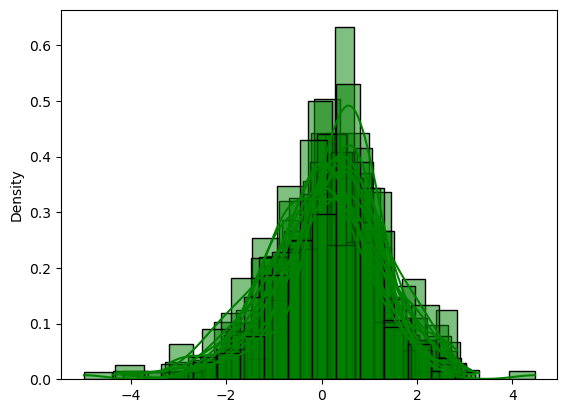

In [20]:
import seaborn as sns
def linear_response(cov_matrix):
    lam, U = np.linalg.eigh(cov_matrix)
    lam = np.clip(lam, 0, None)
    z = np.sqrt(lam)
    R0 = (U * z) @ U.T
    return R0, U, lam, z

def estimate_input(response_matrix, tuning_curves):
    # solve R0 x = dmu for x via least-squares (shared across angles)
    U, s, Vt = np.linalg.svd(response_matrix, full_matrices=False)
    s_inv = np.divide(1.0, s, out=np.zeros_like(s), where=s>1e-12)
    R0_pinv = (Vt.T * s_inv) @ U.T
    return R0_pinv @ tuning_curves

# Delta mu is the difference between each mu and the closest mu 
mu_hat.shape
delta_mu= np.zeros((mu_hat.shape))
for i in range(12):
    dmu1 = mu_hat[i,:] - mu_hat[jnp.mod(i+1,12),:]
    dmu2 = mu_hat[i,:] - mu_hat[jnp.mod(i-1,12),:]
    delta_mu[i,:] = dmu1 if jnp.linalg.norm(dmu1) < jnp.linalg.norm(dmu2) else dmu2
sigma_hat.shape

norms = []
for i in range(12):
    R0, U, lam, z = linear_response(sigma_hat[i,:,:])
    xhat = estimate_input(R0, delta_mu[i,:])
    norms.append(jnp.linalg.norm(xhat)**2/xhat.shape[0])
    sns.histplot(xhat, color='green', stat='density', label='Hungry', kde=True)
print(jnp.mean(jnp.array(norms)), jnp.std(jnp.array(norms))/jnp.sqrt(12))

(7, 5, 10)


Text(0, 0.5, '$| \\hat{\\Delta x} | ^2 \\;/ N$')

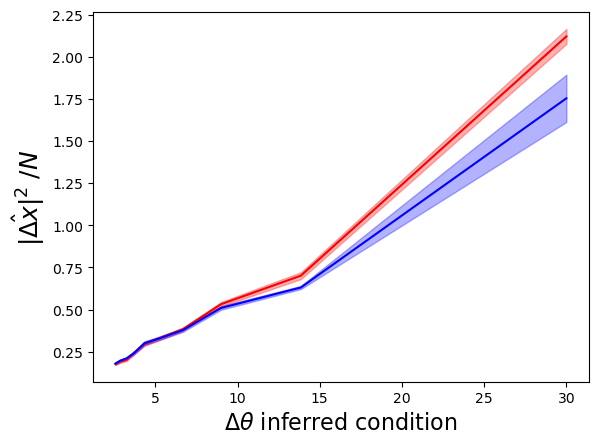

In [54]:
import numpy as np
from matplotlib import pyplot as plt
conditions_array = np.linspace(12,140,10).astype('int')

data = np.load('xhat_results_1.npz')
x_hat_mean_fr_full = data['snr_outputs_mean_fr_full'][:-1,:,:]
x_hat_mean_ctr_full = data['snr_outputs_mean_ctr_full'][:-1,:,:]
print(x_hat_mean_fr_full.shape)
sigma_eta = np.linspace(0.7,1.3,10)
fr_mean = np.nanmean(x_hat_mean_fr_full, axis=1)/(.95*sigma_eta[None,:])**2
ctr_mean = np.nanmean(x_hat_mean_ctr_full, axis=1)/(1.00*sigma_eta[None,:])**2
plt.plot(360/conditions_array, np.mean(fr_mean,axis = 0), label = 'Food Restricted', color = 'red')
plt.fill_between(360/conditions_array, np.mean(fr_mean,axis = 0)-np.std(fr_mean,axis = 0)/np.sqrt(fr_mean.shape[0]), np.mean(fr_mean,axis = 0)+np.std(fr_mean,axis = 0)/np.sqrt(fr_mean.shape[0]), color = 'red', alpha = 0.3)
plt.plot(360/conditions_array, np.mean(ctr_mean,axis = 0), label = 'Control', color = 'blue')
plt.fill_between(360/conditions_array, np.mean(ctr_mean,axis = 0)-np.std(ctr_mean,axis = 0)/np.sqrt(ctr_mean.shape[0]), np.mean(ctr_mean,axis = 0)+np.std(ctr_mean,axis = 0)/np.sqrt(ctr_mean.shape[0]), color = 'blue', alpha = 0.3)
plt.xlabel(r'$\Delta \theta$ inferred condition', fontsize=16)
plt.ylabel(r'$| \hat{\Delta x} | ^2 \;/ N$', fontsize=18)


Posterior mean shape: (12, 128)
Posterior covariance shape: (12, 128, 128)


Text(0, 0.5, 'Mean Overlap')

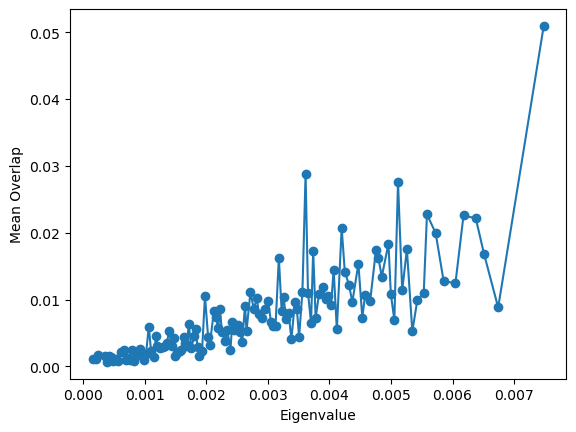

In [11]:
print("Posterior mean shape:", mu_hat.shape)
print("Posterior covariance shape:", sigma_hat.shape)
num_angles = mu_hat.shape[0]
num_evec = sigma_hat.shape[1]
overlaps = np.zeros((num_angles, num_evec))
eig_vals = np.zeros((num_angles, num_evec))
for i in range(num_angles):
    eval, evec = np.linalg.eigh(sigma_hat[i,:,:])
    # evec = evec[:,::-1]  # Sort eigenvectors by eigenvalues in descending order
    # eval = eval[::-1]  # Sort eigenvalues in descending order
    eig_vals[i,:] = eval
    d_mu = mu_hat[i,:] - mu_hat[(i+1)%num_angles,:]
    for j in range(num_evec):
        square_overlap = np.abs(np.dot(d_mu, evec[:,j])**2 / (np.linalg.norm(d_mu)**2 * np.linalg.norm(evec[:,j])**2))
        overlaps[i,j] = square_overlap
mean_overlap = np.mean(overlaps, axis=0)
mean_evals = np.mean(eig_vals, axis=0)
plt.plot(mean_evals,mean_overlap, marker='o')
# for i in range(num_angles):
    # plt.plot(eig_vals[i,:],overlaps[i,:], marker='o', label=f'Angle {i+1}')
plt.xlabel('Eigenvalue')
plt.ylabel('Mean Overlap')


# Trail Sample

In [ ]:
import jax.numpy as jnp
from jax import random

key = random.PRNGKey(0)  # seed for reproducibility
C, N = mu_hat.shape
K = 1000  # number of trials per condition

# Allocate output array
synthetic_trials = jnp.zeros((C, K, N))

# Loop over each condition
for c in range(C):
    key, subkey = random.split(key)
    trials_c = random.multivariate_normal(subkey, mean=mu_hat[c], cov=sigma_hat[c], shape=(K,))
    synthetic_trials = synthetic_trials.at[c].set(trials_c)


In [66]:
np.save('sampled_dim_noise.npy', synthetic_trials)

In [63]:
print(synthetic_trials.shape)
synthetic_trials = np.mean(synthetic_trials, axis=0)  # Average over trials
print(synthetic_trials.shape)

np.save('tom_seb_rochefort_sampled_nc_dim.npy', synthetic_trials)


(120, 10000, 128)
(10000, 128)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


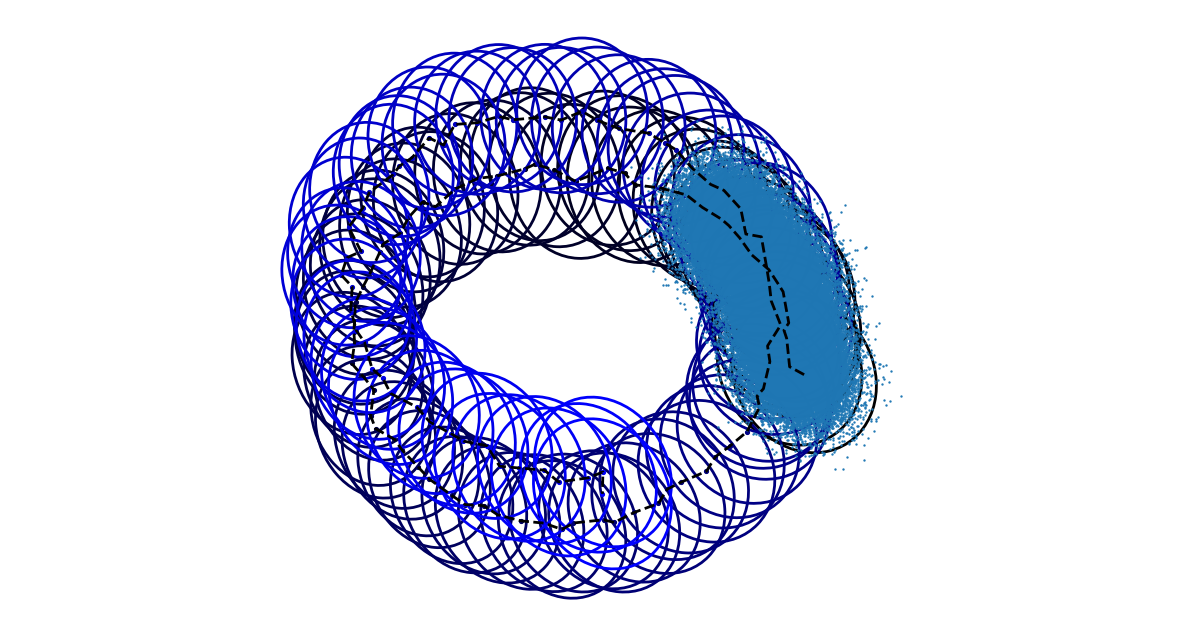

(12, 128, 128)

In [49]:
# synthetic_trials shape: (C, K, N)
mu_synthetic = jnp.mean(synthetic_trials, axis=1)  # (C, N)
sigma_synthetic = jnp.zeros((C, N, N))

for i in range(C):
    df = pd.DataFrame(np.array(synthetic_trials[i]))  # convert to NumPy for Pandas
    cov = df.cov().to_numpy()
    # cov += np.eye(N) * 1e-6  # numerical stability
    sigma_synthetic = sigma_synthetic.at[i].set(cov)


# Flatten synthetic trials across all conditions and trials: (C*K, N)
pc_input = synthetic_trials.reshape(-1, synthetic_trials.shape[-1])

# Pass to visualization (mu needs shape C x 1 x N or C x N x 1 depending on code)
visualizations.visualize_pc(
    mu_test_hat[:, None],  # shape (C, 1, N)
    sigma_test_hat,
    pc=pc_input
)


sigma_synthetic.shape

# Hyper Param Tuning

In [ ]:
def evaluate_hyperparameters(hyperparams, x_train, y_train, x_test, y_test, n_iter=5000):

    # Initialize kernels with the hyperparameters
    periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_m']**2))
    periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_c']**2))
    
    # Set up the model
    gp = models.GaussianProcess(kernel=periodic_kernel_gp, N=N)
    wp = models.WishartProcess(kernel=periodic_kernel_wp, P=hyperparams['p'], V=1e-2*jnp.eye(N), optimize_L=False)
    likelihood = models.NormalConditionalLikelihood(N)
    joint = models.JointGaussianWishartProcess(gp, wp, likelihood)
    
    # Set up variational inference
    inference_seed = 2
    key = jax.random.PRNGKey(inference_seed)
    varfam = inference.VariationalNormal(joint.model)
    adam = optim.Adam(1e-1)
    
    # Train the model
    varfam.infer(adam, x_train, y_train, n_iter=n_iter, key=key)
    joint.update_params(varfam.posterior)
    
    posterior = models.NormalGaussianWishartPosterior(joint,varfam,x_train)
    with numpyro.handlers.seed(rng_seed=inference_seed):
        mu_hat, sigma_hat, F_hat = posterior.sample(x_train)
    mu_empirical = y_train.mean(0)
    log_likelihood = likelihood.log_prob(y_test['x'], mu_empirical, sigma_hat).flatten()

    # # Create posterior and compute log likelihood on validation data
    # posterior = models.NormalGaussianWishartPosterior(joint, varfam, x_train)
    # Compute log likelihood (directly using the posterior's log_prob method)
    # This uses x_val and y_val_data
    # log_likelihood = posterior.log_prob(x_test, y_test['x'])

    return log_likelihood.mean()

def optimize_hyperparameters(x_train, y_train, x_val, y_val, hyperparam_grid, n_iter=5000):
    
    # Generate all combinations of hyperparameters
    keys = list(hyperparam_grid.keys())
    values = list(hyperparam_grid.values())
    hyperparameter_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]
    
        
    best_score = float('-inf')  # For log-likelihood, higher is better
    best_hyperparams = None
    
    for i, hyperparams in enumerate(tqdm(hyperparameter_combinations)):
        try:
            print(f"\nEvaluating hyperparameters {i+1}/{len(hyperparameter_combinations)}:")
            score = evaluate_hyperparameters(hyperparams, x_train, y_train, x_val, y_val, n_iter)
            
            print(f"Score: {score}")
            
            # Update best if needed
            if score > best_score:
                best_score = score
                best_hyperparams = hyperparams
                print(f"New best score: {best_score}")
                
        except Exception as e:
            print(f"Error with hyperparams {hyperparams}: {str(e)}")
            continue
    
    return best_hyperparams, best_score

# Main execution
if __name__ == "__main__":
    # Split data
    data = utils.split_data(x=X_CONDITIONS[:, None], y=TEST_RESPONSE, 
                           train_trial_prop=0.8, train_condition_prop=0.8, seed=SEED)
    x_train, y_train, _, _, x_test, y_test, _, _, _, _, _, _, _, _ = data
    
    print('x conditions train ', x_train.shape)     # x_train 80% of conditions: 9/12

    print('y data train ', y_train.shape)     # ytrain 80% conditions and trials : 9/12, 8/11

    print('x conditions val ', x_test.shape)     # x_test 20% of conditions: 3/12

    print('y_val, (x) ', y_test['x'].shape)     # y_test['x'] 20% of trials and 80% conditions: 9/12, 3/11

    print('y_val, (x_test) ', y_test['x_test'].shape)     # y_test['x_test'] 100% of trials and 20% conditions: 3/12, 11/11
    x_train = x_train.reshape(x_train.shape[0])
    x_test = x_test.reshape(x_test.shape[0])

    # Define a more focused hyperparameter grid
    hyperparam_grid = {
        'sigma_m': [0.1,0.2,0.3,0.4, 0.5,0.6,0.7, 1.0,5],
        'gamma_gp': [1e-6,1e-5,1e-4,1e-3],
        'beta_gp': [1e-1,1,1e1,1e2],
        'sigma_c': [0.1,0.2,0.3,0.4, 0.5,0.6,0.7, 1.0,5],
        'gamma_wp': [1e-6,1e-5,1e-4,1e-3],
        'beta_wp': [1e-1,1,1e1,1e2],
        'p': [N+1]
    }
    hyperparam_grid = {
    'sigma_m': [0.5,1,2],
    'gamma_gp': [1e-6],
    'beta_gp': [1e-1],
    'sigma_c': [0.5,1],
    'gamma_wp': [1e-6],
    'beta_wp': [1e-1,1],
    'p': [N+1]
    }
    
    # Run optimization with a time budget of 12 hours
    best_hyperparams, best_score = optimize_hyperparameters(
        x_train, y_train, x_test, y_test, 
        hyperparam_grid, 
        n_iter=400)
    
    print("\n=== Optimization Results ===")
    print(f"Best hyperparameters:")
    for k, v in best_hyperparams.items():
        print(f"  {k}: {v}")
    print(f"Best score: {best_score}")

# Compare to Empirical

(12, 128)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


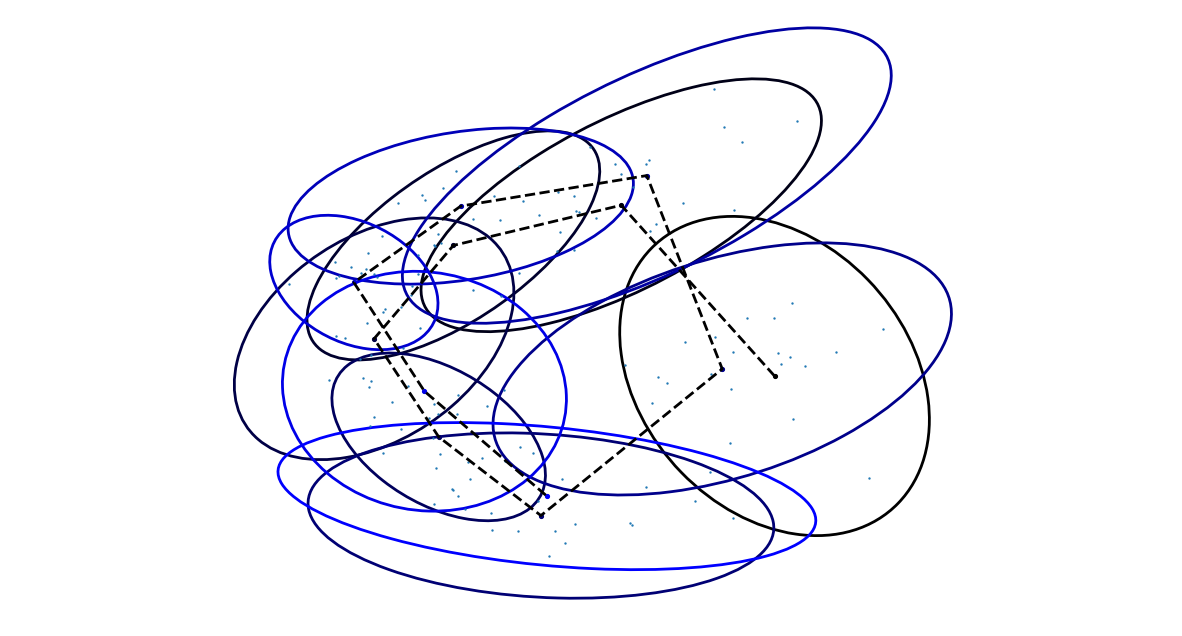

In [17]:
import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)



# Test Unseen conditions 

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


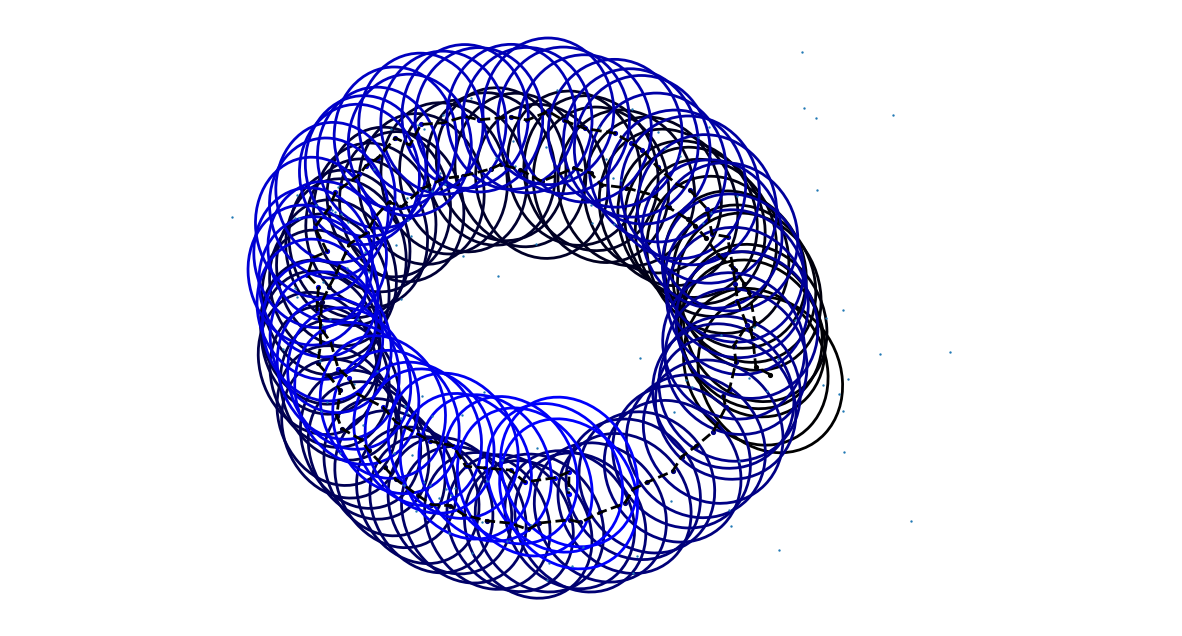

In [47]:
with numpyro.handlers.seed(rng_seed=1):
    X_TEST_CONDITIONS = jnp.linspace(0, C-1, 120)
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(X_TEST_CONDITIONS)

    visualizations.visualize_pc(
        mu_test_hat[:,None],sigma_test_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
    )


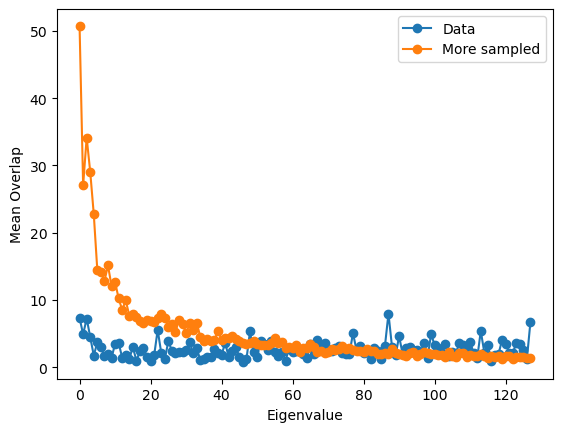

In [13]:
num_angles = mu_test_hat.shape[0]
num_evec = sigma_test_hat.shape[1]
overlaps = np.zeros((num_angles, num_evec))
eig_vals = np.zeros((num_angles, num_evec))
for i in range(num_angles):
    eval, evec = np.linalg.eigh(sigma_test_hat[i,:,:])
    # evec = evec[:,::-1]  # Sort eigenvectors by eigenvalues in descending order
    # eval = eval[::-1]  # Sort eigenvalues in descending order
    eig_vals[i,:] = eval
    d_mu = mu_test_hat[i,:] - mu_test_hat[(i+1)%num_angles,:]
    for j in range(num_evec):
        square_overlap = np.abs(np.dot(d_mu, evec[:,j])**2 / (np.linalg.norm(d_mu)**2 * np.linalg.norm(evec[:,j])**2))
        overlaps[i,j] = square_overlap
mean_overlap2 = np.mean(overlaps, axis=0)
mean_evals2 = np.mean(eig_vals, axis=0)
# plt.plot(mean_evals,mean_overlap, marker='o', label='Data')
# plt.plot(mean_evals2,mean_overlap2, marker='o', label='More sampled')


plt.plot(mean_overlap/mean_evals, marker='o', label='Data')
plt.plot(mean_overlap2/mean_evals2, marker='o', label='More sampled')


plt.xlabel('Eigenvalue')
plt.ylabel('Mean Overlap')
plt.legend()




# FISHER INFORMATION

In [ ]:
with numpyro.handlers.seed(rng_seed=1):

    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)
    mu_prime, sigma_prime = posterior.derivative(X_CONDITIONS)

    # Compute Fisher Information
    fi = evaluation.fisher_information(X_CONDITIONS,mu_prime,sigma_hat,sigma_prime)
    print(fi.shape)
    print(fi)


def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered

In [26]:
ctr_fisher = np.load('ctr_fisher_info.npy', allow_pickle=True)
fr_fisher = np.load('fr_fisher_info.npy', allow_pickle=True)

Mann-Whitney U statistic: 19.0, p-value: 0.5727605727605728


/tmp/ipykernel_247113/4221620351.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ctr_fisher_per_animal, fr_fisher_per_animal], labels=['Control', 'Food Restricted'])


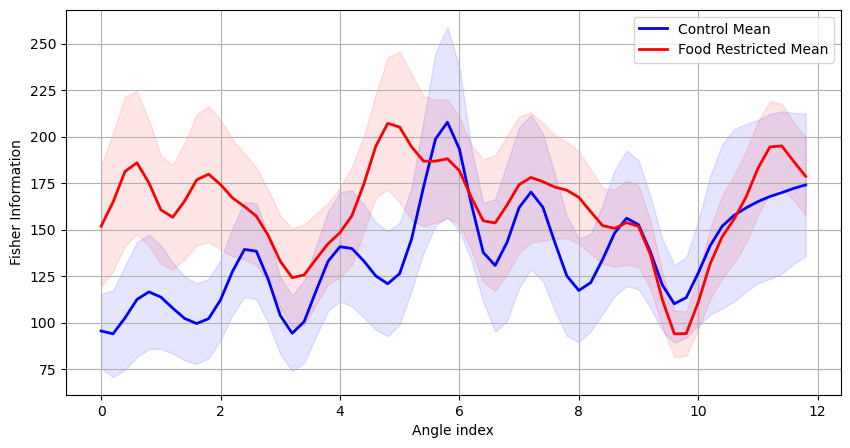

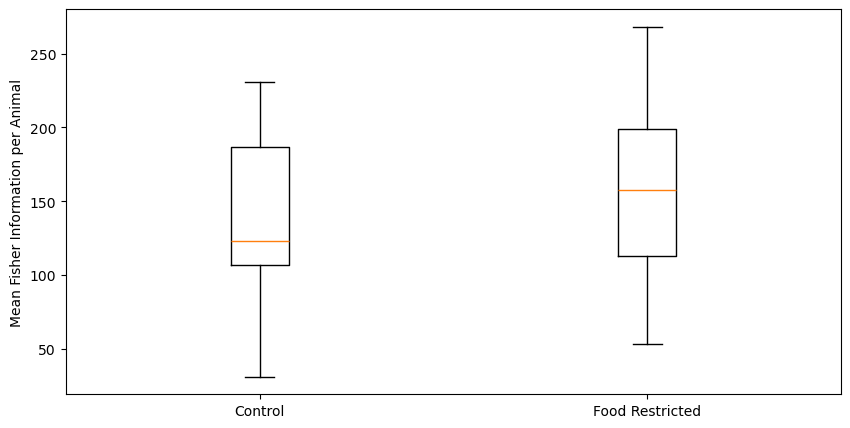

In [39]:
plt.figure(figsize=(10, 5))
# Average over the first index (animals), so shape becomes (n_angles,)

ctr_fisher_mean = np.mean(ctr_fisher, axis=0)
fr_fisher_mean = np.mean(fr_fisher, axis=0)
angles = np.arange(0, 12, 12/60)

# Plot for each animal
# for i in range(ctr_fisher.shape[0]):
#     plt.plot(angles, ctr_fisher[i], color='blue', alpha=0.3)
# for i in range(fr_fisher.shape[0]):
#     plt.plot(angles, fr_fisher[i], color='red', alpha=0.3)

# Plot mean
plt.plot(angles, ctr_fisher_mean, label='Control Mean', color='blue', linewidth=2)
plt.fill_between(
    angles,
    ctr_fisher_mean - np.std(ctr_fisher, axis=0) / np.sqrt(ctr_fisher.shape[0]),
    ctr_fisher_mean + np.std(ctr_fisher, axis=0) / np.sqrt(ctr_fisher.shape[0]),
    color='blue', alpha=0.1
)
plt.plot(angles, fr_fisher_mean, label='Food Restricted Mean', color='red', linewidth=2)
plt.fill_between(
    angles,
    fr_fisher_mean - np.std(fr_fisher, axis=0) / np.sqrt(fr_fisher.shape[0]),
    fr_fisher_mean + np.std(fr_fisher, axis=0) / np.sqrt(fr_fisher.shape[0]),
    color='red', alpha=0.1
)

plt.xlabel('Angle index')
plt.ylabel('Fisher Information')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
# Box plot: each box is the mean Fisher info per animal
ctr_fisher_per_animal = np.mean(ctr_fisher, axis=1)
fr_fisher_per_animal = np.mean(fr_fisher, axis=1)
plt.boxplot([ctr_fisher_per_animal, fr_fisher_per_animal], labels=['Control', 'Food Restricted'])
plt.ylabel('Mean Fisher Information per Animal')

from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(ctr_fisher_per_animal, fr_fisher_per_animal)
print(f'Mann-Whitney U statistic: {u_stat}, p-value: {p_value}')

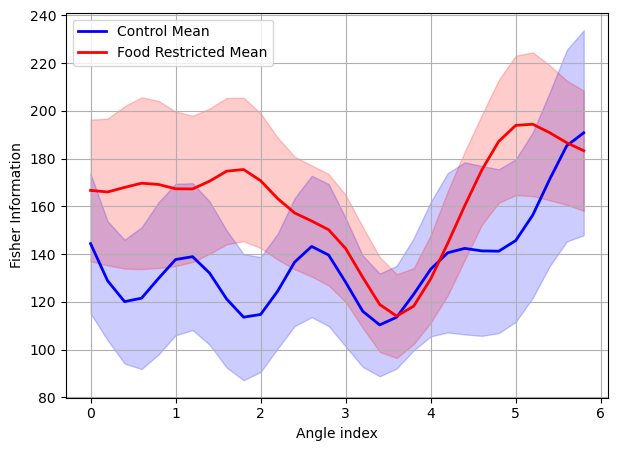

In [36]:
ctr_fisher_folded = np.zeros((ctr_fisher.shape[0], ctr_fisher.shape[1]//2))
fr_fisher_folded = np.zeros((fr_fisher.shape[0], fr_fisher.shape[1]//2))

for i in range(ctr_fisher.shape[1]//2):
    ctr_fisher_folded[:,i] = (ctr_fisher[:,i] + ctr_fisher[:,ctr_fisher.shape[1]//2+i])/2
    fr_fisher_folded[:,i] = (fr_fisher[:,i] + fr_fisher[:,ctr_fisher.shape[1]//2+i])/2


plt.figure(figsize=(7, 5))
# Average over the first index (animals), so shape becomes (n_angles,)
ctr_fisher_mean = np.mean(ctr_fisher_folded, axis=0)
fr_fisher_mean = np.mean(fr_fisher_folded, axis=0)
angles = np.arange(0, 6, 6/30)
# Plot for each animal
# for i in range(ctr_fisher_folded.shape[0]):
#     plt.plot(angles, ctr_fisher_folded[i], color='blue', alpha=0.3)
 
# for i in range(fr_fisher_folded.shape[0]):
#     plt.plot(angles, fr_fisher_folded[i], color='red', alpha=0.3)

# Plot mean
plt.plot(angles, ctr_fisher_mean, label='Control Mean', color='blue', linewidth=2)
plt.fill_between(
    angles,
    ctr_fisher_mean - np.std(ctr_fisher_folded, axis=0) / np.sqrt(ctr_fisher_folded.shape[0]),
    ctr_fisher_mean + np.std(ctr_fisher_folded, axis=0) / np.sqrt(ctr_fisher_folded.shape[0]),
    color='blue', alpha=0.2
)
plt.plot(angles, fr_fisher_mean, label='Food Restricted Mean', color='red', linewidth=2)
plt.fill_between(
    angles,
    fr_fisher_mean - np.std(fr_fisher_folded, axis=0) / np.sqrt(fr_fisher_folded.shape[0]),
    fr_fisher_mean + np.std(fr_fisher_folded, axis=0) / np.sqrt(fr_fisher_folded.shape[0]),
    color='red', alpha=0.2
)
plt.xlabel('Angle index')
plt.ylabel('Fisher Information')
plt.legend()
plt.grid()
plt.show()

# Plotting sUPER 

overlaps_fr_normal shape: (8, 12, 5, 50)
eigs_fr_normal shape: (8, 12, 5, 50)
total_snr fr: 58.420406351060386
total_snr fr super: 13.128014045476705
total_snr ctr: 53.19742978945645
total_snr ctr super: 13.323719121764372


(array([0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014, 0.0016,
        0.0018]),
 [Text(0, 0.0002, '0.0002'),
  Text(0, 0.0004, '0.0004'),
  Text(0, 0.0006000000000000001, '0.0006'),
  Text(0, 0.0008, '0.0008'),
  Text(0, 0.001, '0.0010'),
  Text(0, 0.0012000000000000001, '0.0012'),
  Text(0, 0.0014000000000000002, '0.0014'),
  Text(0, 0.0016, '0.0016'),
  Text(0, 0.0018000000000000002, '0.0018')])

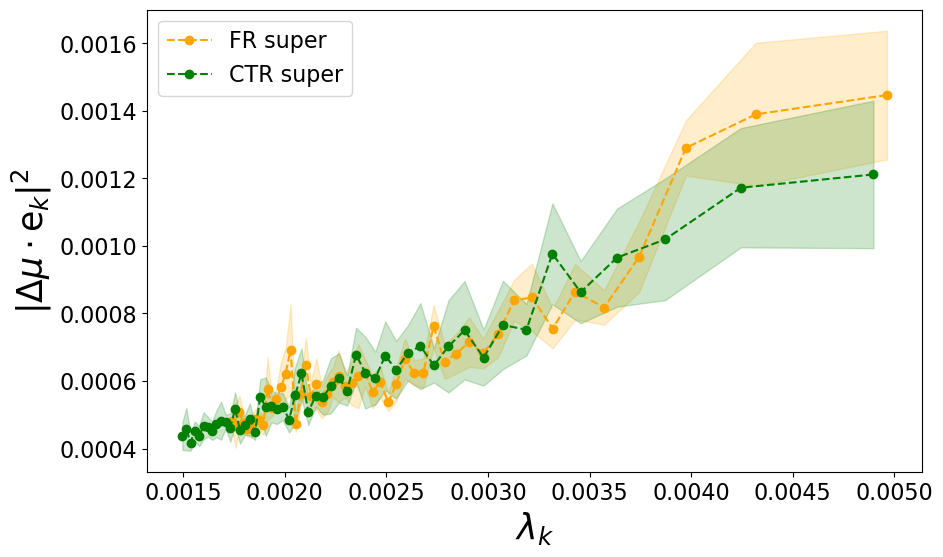

In [5]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load('../Data/overlaps_sated_food_restricted_super_10.npz')
overlaps_fr_normal = data['overlaps_fr_normal']
eigs_fr_normal = data['eigs_fr_normal']
overlaps_fr_super = data['overlaps_fr_super']
eigs_fr_super = data['eigs_fr_super']

print('overlaps_fr_normal shape:', overlaps_fr_normal.shape)
print('eigs_fr_normal shape:', eigs_fr_normal.shape)

def extract_plot_vectors(overlaps, eigs):
    total_k = eigs.shape[-1]
    n_anim = overlaps.shape[0]
    evals_plot = np.zeros((n_anim, total_k))
    dots_plot  = np.zeros((n_anim, total_k))

    for i in range(n_anim):
        evals_plot[i] = np.nanmean(eigs[i,:,:,:], axis=(0,1))
        dots_plot[i] = np.nanmean(overlaps[i,:,:,:], axis=(0,1)) # → (total_k,)

    return evals_plot, dots_plot, 

# Extract for each group
fr_evals_plot, fr_dots_plot = extract_plot_vectors(overlaps_fr_normal, eigs_fr_normal)

# Panel 1: eigenvalue size vs dot product, with across‐animal mean ± SEM
x_fr = np.nanmean(fr_evals_plot, axis=0)
y_fr = np.nanmean(fr_dots_plot, axis=0)
sem_fr = np.nanstd(fr_dots_plot, axis=0, ddof=1) / np.sqrt(fr_dots_plot.shape[0])

plt.figure(figsize=(10, 6))
# plt.plot(x_fr, y_fr, 'o--', color='red',   label='FR')
# plt.fill_between(x_fr, y_fr - sem_fr, y_fr + sem_fr, color='red',   alpha=0.2)

print('total_snr fr:', np.sum((y_fr/x_fr)))

fr_evals_plot, fr_dots_plot = extract_plot_vectors(overlaps_fr_super, eigs_fr_super)
x_fr = np.nanmean(fr_evals_plot, axis=0)
y_fr = np.nanmean(fr_dots_plot, axis=0)
sem_fr = np.nanstd(fr_dots_plot, axis=0, ddof=1) / np.sqrt(fr_dots_plot.shape[0])

plt.plot(x_fr, y_fr, 'o--', color='orange',   label='FR super')
plt.fill_between(x_fr, y_fr - sem_fr, y_fr + sem_fr, color='orange',   alpha=0.2)
print('total_snr fr super:', np.sum((y_fr/x_fr)))


data = np.load('../Data/overlaps_sated_control_super_10.npz')
overlaps_ctr_normal = data['overlaps_ctr_normal']
eigs_ctr_normal = data['eigs_ctr_normal']
overlaps_ctr_super = data['overlaps_ctr_super']
eigs_ctr_super = data['eigs_ctr_super']


# Extract for each group
ctr_evals_plot, ctr_dots_plot = extract_plot_vectors(overlaps_ctr_normal, eigs_ctr_normal)
# Panel 1: eigenvalue size vs dot product, with across‐animal mean ± SEM
x_ctr = np.nanmean(ctr_evals_plot, axis=0)
y_ctr = np.nanmean(ctr_dots_plot, axis=0)
sem_ctr = np.nanstd(ctr_dots_plot, axis=0, ddof=1) / np.sqrt(ctr_dots_plot.shape[0])
# plt.plot(x_ctr, y_ctr, 'o--', color='blue', label='CTR ')
# plt.fill_between(x_ctr, y_ctr - sem_ctr, y_ctr + sem_ctr, color='blue', alpha=0.2) 
print('total_snr ctr:', np.sum((y_ctr/x_ctr)))
     
# Extract for each group
ctr_evals_plot, ctr_dots_plot = extract_plot_vectors(overlaps_ctr_super, eigs_ctr_super)
x_ctr = np.nanmean(ctr_evals_plot, axis=0)
y_ctr = np.nanmean(ctr_dots_plot, axis=0)
sem_ctr = np.nanstd(ctr_dots_plot, axis=0, ddof=1) / np.sqrt(ctr_dots_plot.shape[0])
plt.plot(x_ctr, y_ctr, 'o--', color='green', label='CTR super')
plt.fill_between(x_ctr, y_ctr - sem_ctr, y_ctr + sem_ctr, color='green', alpha=0.2) 
print('total_snr ctr super:', np.sum((y_ctr/x_ctr)))




plt.xlabel(r'$\lambda_k$',fontsize = 25)
plt.ylabel(r'$|\Delta \mu \cdot \text{e}_k|^2$',fontsize = 25)
# plt.ylabel(r'$\cos^2(\theta_k)$', fontsize = 25)
plt.legend(fontsize =16, loc='upper left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('eigenvalue_dot_product.svg',bbox_inches='tight')

## SNR Overall Bar

(12, 5, 162) (12, 5, 162) (48, 5, 162) (48, 5, 162)
(12, 5, 106) (12, 5, 106) (48, 5, 106) (48, 5, 106)
(12, 5, 114) (12, 5, 114) (48, 5, 114) (48, 5, 114)
(12, 5, 136) (12, 5, 136) (48, 5, 136) (48, 5, 136)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 109) (12, 5, 109) (48, 5, 109) (48, 5, 109)
(12, 5, 235) (12, 5, 235) (48, 5, 235) (48, 5, 235)
(12, 5, 129) (12, 5, 129) (48, 5, 129) (48, 5, 129)
(12, 5, 137) (12, 5, 137) (48, 5, 137) (48, 5, 137)
(12, 5, 112) (12, 5, 112) (48, 5, 112) (48, 5, 112)
(12, 5, 56) (12, 5, 56) (48, 5, 56) (48, 5, 56)
(12, 5, 94) (12, 5, 94) (48, 5, 94) (48, 5, 94)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 134) (12, 5, 134) (48, 5, 134) (48, 5, 134)


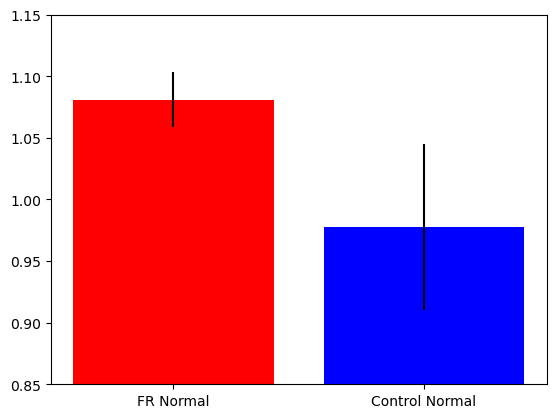

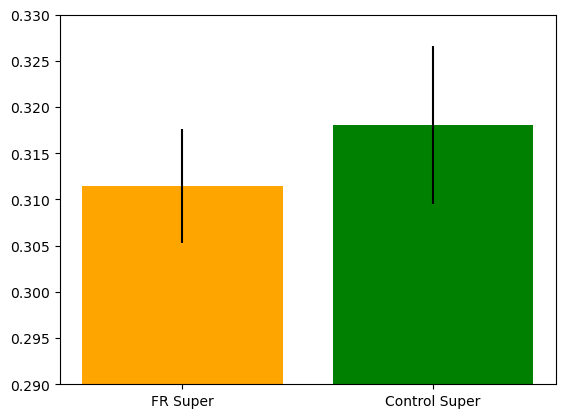

In [6]:
import numpy as np
from types import SimpleNamespace

rag_fr = np.load('../Data/overlaps_sated_fr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str



FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

import matplotlib.pyplot as plt

average_fr_normal = []
average_fr_super = []
for animal in FOOD_RESTRICTED_SATED:
    normal_overlaps = overlaps_normal_dict_fr[animal]
    normal_eigs = eigs_normal_dict_fr[animal]
    super_overlaps = overlaps_super_dict_fr[animal]
    super_eigs = eigs_super_dict_fr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_fr_normal.append(np.nanmean(mean_snr))
    average_fr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)

average_ctr_normal = []
average_ctr_super = []
for animal in CONTROL_SATED:
    normal_overlaps = overlaps_normal_dict_ctr[animal]
    normal_eigs = eigs_normal_dict_ctr[animal]
    super_overlaps = overlaps_super_dict_ctr[animal]
    super_eigs = eigs_super_dict_ctr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_ctr_normal.append(np.nanmean(mean_snr))
    average_ctr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)
plt.bar([0,1], [np.mean(average_fr_normal), np.mean(average_ctr_normal)], yerr=[np.std(average_fr_normal)/np.sqrt(len(average_fr_normal)), np.std(average_ctr_normal)/np.sqrt(len(average_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.15)
plt.show()
plt.bar([0,1], [np.mean(average_fr_super), np.mean(average_ctr_super)], yerr=[np.std(average_fr_super)/np.sqrt(len(average_fr_super)), np.std(average_ctr_super)/np.sqrt(len(average_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.29,0.33)
plt.show()


# Check

FR Normal: n=8, mean=1.081, SEM=0.02383
  Top variance contributor: idx=0, value=1.22
  Contribution to variance: 60.6%
  SEM if dropped: 0.01526  (change: +36.0%)
  ↳ Error likely dominated by a single value.
Control Normal: n=6, mean=0.9774, SEM=0.07394
  Top variance contributor: idx=0, value=1.302
  Contribution to variance: 64.2%
  SEM if dropped: 0.04336  (change: +41.4%)
  ↳ Error likely dominated by a single value.
FR Super: n=8, mean=0.3115, SEM=0.006585
  Top variance contributor: idx=4, value=0.3536
  Contribution to variance: 73.1%
  SEM if dropped: 0.003079  (change: +53.2%)
  ↳ Error likely dominated by a single value.
Control Super: n=6, mean=0.3181, SEM=0.009346
  Top variance contributor: idx=5, value=0.274
  Contribution to variance: 74.0%
  SEM if dropped: 0.003834  (change: +59.0%)
  ↳ Error likely dominated by a single value.


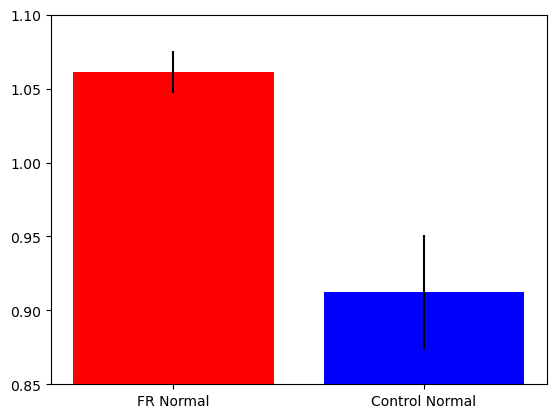

(0.29, 0.34)

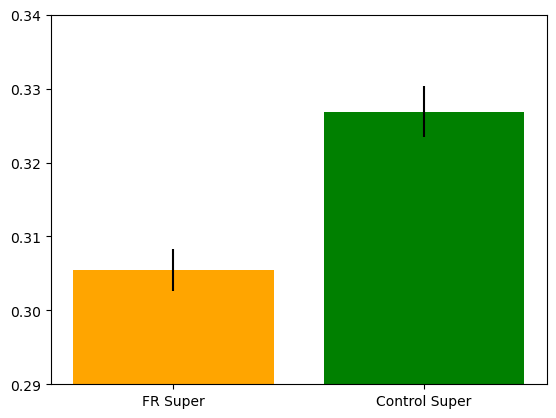

In [7]:
def sem_influence(x, name="group"):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        print(f"{name}: empty array"); 
        return

    mu = x.mean()
    sd = x.std(ddof=1) if n > 1 else 0.0
    sem = sd / np.sqrt(n) if n > 1 else 0.0

    # Variance contribution of each point
    r2 = (x - mu)**2
    total_ss = r2.sum()
    contrib = r2 / total_ss if total_ss > 0 else np.zeros_like(x)

    # Leave-one-out SEM (undefined for n<3)
    if n >= 3:
        loo_sem = np.array([
            np.std(np.delete(x, i), ddof=1) / np.sqrt(n - 1) for i in range(n)
        ])
        # How much SEM drops if we remove point i (positive = this point inflates SEM)
        sem_drop = sem - loo_sem
    else:
        loo_sem = np.full(n, np.nan)
        sem_drop = np.full(n, np.nan)

    # Report top influencer
    i_top = int(np.nanargmax(contrib))
    dominance = contrib[i_top]
    drop_pct = (sem_drop[i_top] / sem) * 100 if sem > 0 and np.isfinite(sem_drop[i_top]) else np.nan

    print(f"{name}: n={n}, mean={mu:.4g}, SEM={sem:.4g}")
    print(f"  Top variance contributor: idx={i_top}, value={x[i_top]:.4g}")
    print(f"  Contribution to variance: {dominance*100:.1f}%")
    if np.isfinite(drop_pct):
        print(f"  SEM if dropped: {loo_sem[i_top]:.4g}  (change: {drop_pct:+.1f}%)")

    # Optional: simple dominance flags
    dominated = (dominance > 0.5) or (np.isfinite(drop_pct) and drop_pct > 30)
    if dominated:
        print("  ↳ Error likely dominated by a single value.")
    else:
        print("  ↳ No single value appears to dominate.")
    
    #return index of top influencer
    return i_top

# Use on your data:
itop_fr_n = sem_influence(average_fr_normal,   "FR Normal")
itop_ctr_n = sem_influence(average_ctr_normal,  "Control Normal")
itop_fr_s = sem_influence(average_fr_super,    "FR Super")
itop_ctr_s = sem_influence(average_ctr_super,   "Control Super")


dropped_fr_normal = [x for i,x in enumerate(average_fr_normal) if i!=itop_fr_n]
dropped_ctr_normal = [x for i,x in enumerate(average_ctr_normal) if i!=itop_ctr_n]
dropped_fr_super = [x for i,x in enumerate(average_fr_super) if i!=itop_fr_s]
dropped_ctr_super = [x for i,x in enumerate(average_ctr_super) if i!=itop_ctr_s]
plt.bar([0,1], [np.mean(dropped_fr_normal), np.mean(dropped_ctr_normal)], yerr=[np.std(dropped_fr_normal)/np.sqrt(len(dropped_fr_normal)), np.std(dropped_ctr_normal)/np.sqrt(len(dropped_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.10)
plt.show()
plt.bar([0,1], [np.mean(dropped_fr_super), np.mean(dropped_ctr_super)], yerr=[np.std(dropped_fr_super)/np.sqrt(len(dropped_fr_super)), np.std(dropped_ctr_super)/np.sqrt(len(dropped_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.29,0.34)

## SNR overall Line

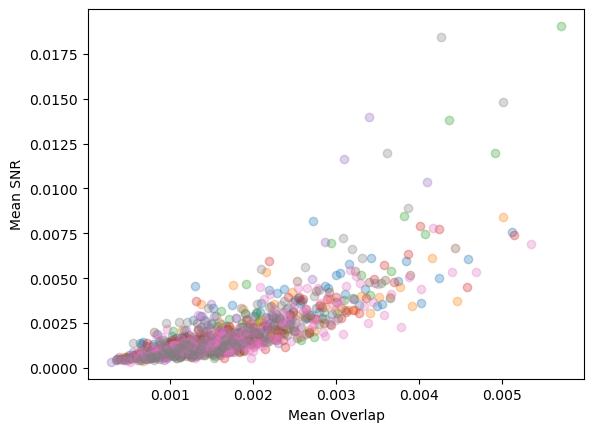

In [8]:
import numpy as np

rag_fr = np.load('../Data/overlaps_sated_fr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str



FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

import matplotlib.pyplot as plt


for animal in FOOD_RESTRICTED_SATED:
    normal_overlaps = overlaps_normal_dict_fr[animal]
    normal_eigs = eigs_normal_dict_fr[animal]
    super_overlaps = overlaps_super_dict_fr[animal]
    super_eigs = eigs_super_dict_fr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))
    # plt.scatter(np.nanmean(normal_eigs,axis = (0,1)),mean_snr, alpha=0.3)
    # plt.scatter(np.nanmean(normal_overlaps,axis = (0,1)),mean_snr, alpha=0.3)
    plt.scatter(np.nanmean(normal_eigs,axis = (0,1)),np.nanmean(normal_overlaps,axis = (0,1)), alpha=0.3)


    plt.xlabel('Mean Overlap')
    plt.ylabel('Mean SNR')
    # plt.plot(mean_snr_super, marker='o', color='blue', alpha=0.3)
    # plt.show()

for animal in CONTROL_SATED:
    normal_overlaps = overlaps_normal_dict_ctr[animal]
    normal_eigs = eigs_normal_dict_ctr[animal]
    super_overlaps = overlaps_super_dict_ctr[animal]
    super_eigs = eigs_super_dict_ctr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --------- internal helpers ---------
def _pairwise_flatten_xy(x, y):
    x = np.asarray(x); y = np.asarray(y)
    if x.shape != y.shape:
        raise ValueError(f"x and y must match in shape per animal, got {x.shape} vs {y.shape}")
    x1 = x.ravel(); y1 = y.ravel()
    m = np.isfinite(x1) & np.isfinite(y1)
    return x1[m], y1[m]

def _fit_line_ols(x, y):
    # returns (a, b) for y ~ a + b*x ; None if not enough info
    if x.size < 2 or np.unique(x).size < 2:
        return None
    b, a = np.polyfit(x, y, 1)   # slope, intercept
    return a, b

def _make_common_grid_from_ranges(ranges, pooled_x, n=300, percentiles=(5, 95)):
    if len(ranges) > 0:
        lo = max(lo_i for (lo_i, hi_i) in ranges)
        hi = min(hi_i for (lo_i, hi_i) in ranges)
    else:
        lo, hi = np.nan, np.nan
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = np.percentile(pooled_x, list(percentiles))
    return np.linspace(lo, hi, n)

# --------- main function ---------
def fit_group_lines(
    animals,
    overlaps_dict,
    eigs_dict,
    mean_axes=(0, 1),
    *,
    label="Group",
    ax=None,
    color=None,
    show_scatter=True,
    scatter_alpha=0.25,
    n_grid=300,
    grid_percentiles=(5, 95),
    x_grid=None,                      # optional: enforce a common grid for fair comparison across groups
    plot_model1=True,
    plot_model2=True
):
    """
    Fit and (optionally) plot Model 1 & 2 for a single group.

    Parameters
    ----------
    animals : iterable
        Sequence of animal identifiers (keys into *overlaps_dict* and *eigs_dict*).
    overlaps_dict, eigs_dict : dict
        Dict[animal] -> array-like. Will be reduced by np.nanmean over *mean_axes* and then flattened.
        After reduction, x = mean(eigs), y = mean(overlaps) must have the same shape per animal.
    mean_axes : tuple
        Axes to average over before fitting (default (0,1), as per your code snippet).
    label : str
        Label used in the plot legend and in the returned structure.
    ax : matplotlib Axes or None
        If None, a new figure/axes is created.
    color : any Matplotlib color
    show_scatter : bool
        Whether to scatter pooled points for context.
    scatter_alpha : float
    n_grid : int
        Number of x grid points for predictions.
    grid_percentiles : (low, high)
        Percentiles used for fallback grid when ranges don't overlap well.
    x_grid : np.ndarray or None
        If provided, predictions are made on this grid (useful for comparing multiple groups on the same grid).
        If None, a grid is built from the per-animal ranges (with fallback to pooled percentiles).
    plot_model1, plot_model2 : bool
        Toggle which model curves to draw.

    Returns
    -------
    result : dict with keys:
        - 'label'
        - 'used_animals_m1' : list of animals used in Model 1
        - 'per_animal_coefs' : dict animal -> (a_i, b_i) for Model 1
        - 'x_grid'
        - 'm1_mean_y', 'm1_ci95_y' : arrays on x_grid (if Model 1 succeeded)
        - 'm2_coef' : (a_wls, b_wls) or None
        - 'm2_cov'  : 2x2 covariance of (a,b) or None
        - 'm2_yhat', 'm2_ci95_yhat' : arrays on x_grid (if Model 2 succeeded)
        - 'pooled_x', 'pooled_y' : all pooled points used
        - 'per_animal_ranges' : list of (xmin, xmax)
    """
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4.5))
        created_ax = True

    # ---- collect per-animal points ----
    per_animal_xy = []
    all_x_points, all_y_points = [], []
    for animal in animals:
        y_arr = np.nanmean(overlaps_dict[animal], axis=mean_axes)
        x_arr = np.nanmean(eigs_dict[animal],     axis=mean_axes)
        x_i, y_i = _pairwise_flatten_xy(x_arr, y_arr)
        if x_i.size == 0:
            continue
        per_animal_xy.append((animal, x_i, y_i))
        all_x_points.append(x_i)
        all_y_points.append(y_i)

    if not per_animal_xy:
        raise RuntimeError(f"[{label}] No usable (x,y) points after NaN filtering.")

    pooled_x = np.concatenate(all_x_points)
    pooled_y = np.concatenate(all_y_points)

    if show_scatter:
        ax.scatter(pooled_x, pooled_y, s=12, alpha=scatter_alpha, label=None, color=color)

    # ---- Model 1: per-animal fits -> average predictions ----
    per_animal_coefs = {}
    ranges = []
    for animal, x_i, y_i in per_animal_xy:
        coef = _fit_line_ols(x_i, y_i)
        if coef is not None:
            per_animal_coefs[animal] = coef
            ranges.append((np.nanmin(x_i), np.nanmax(x_i)))

    m1_mean_y = m1_ci95_y = None
    used_animals_m1 = list(per_animal_coefs.keys())

    if len(per_animal_coefs) >= 1:
        grid = x_grid if x_grid is not None else _make_common_grid_from_ranges(
            ranges, pooled_x, n=n_grid, percentiles=grid_percentiles
        )
        Yhat = []
        for animal, (a_i, b_i) in per_animal_coefs.items():
            Yhat.append(a_i + b_i * grid)
        Yhat = np.vstack(Yhat)
        m1_mean_y = Yhat.mean(axis=0)
        sem = Yhat.std(axis=0, ddof=1) / np.sqrt(Yhat.shape[0]) if Yhat.shape[0] > 1 else np.zeros_like(m1_mean_y)
        m1_ci95_y = 1.96 * sem

        if plot_model1:
            ax.plot(grid, m1_mean_y, lw=2, label=f"{label} · Model 1 (n={Yhat.shape[0]})", color=color)
            ax.fill_between(grid, m1_mean_y - m1_ci95_y, m1_mean_y + m1_ci95_y,
                            alpha=0.20, linewidth=0, color=color)

        x_grid_used = grid
    else:
        x_grid_used = x_grid if x_grid is not None else _make_common_grid_from_ranges(
            [], pooled_x, n=n_grid, percentiles=grid_percentiles
        )

    # ---- Model 2: pooled WLS with per-point weight 1/n_i (equal weight per animal) ----
    X_list, y_list, w_list = [], [], []
    for animal, x_i, y_i in per_animal_xy:
        n_i = x_i.size
        if n_i < 2 or np.unique(x_i).size < 2:
            continue
        X_list.append(np.c_[np.ones(n_i), x_i])
        y_list.append(y_i)
        w_list.append(np.full(n_i, 1.0 / n_i))

    m2_coef = m2_cov = m2_yhat = m2_ci95_yhat = None
    if X_list:
        X = np.vstack(X_list)
        y = np.concatenate(y_list)
        w = np.concatenate(w_list)

        sqrtw = np.sqrt(w)
        Xw = X * sqrtw[:, None]
        yw = y * sqrtw

        beta = np.linalg.lstsq(Xw, yw, rcond=None)[0]  # [a, b]
        a_wls, b_wls = beta

        # residual variance & covariance of beta
        resid = yw - Xw @ beta
        dof = max(Xw.shape[0] - 2, 1)
        sigma2 = (resid @ resid) / dof
        XtX_inv = np.linalg.inv(Xw.T @ Xw)
        cov_beta = sigma2 * XtX_inv

        Phi = np.stack([np.ones_like(x_grid_used), x_grid_used], axis=1)
        var_pred = np.einsum('ij,jk,ik->i', Phi, cov_beta, Phi)
        m2_yhat = a_wls + b_wls * x_grid_used
        m2_ci95_yhat = 1.96 * np.sqrt(np.maximum(var_pred, 0.0))

        if plot_model2:
            ax.plot(x_grid_used, m2_yhat, lw=2, ls='--', label=f"{label} · Model 2 (WLS)", color=color)
            ax.fill_between(x_grid_used, m2_yhat - m2_ci95_yhat, m2_yhat + m2_ci95_yhat,
                            alpha=0.15, linewidth=0, color=color)

        m2_coef = (a_wls, b_wls)
        m2_cov = cov_beta

    # ---- finalize plot ----
    if created_ax:
        ax.set_xlabel('mean_normal_eigs (x)')
        ax.set_ylabel('mean_normal_overlaps (y)')
        ax.set_title('Average relation across animals')
        ax.legend(frameon=False)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return dict(
        label=label,
        used_animals_m1=used_animals_m1,
        per_animal_coefs=per_animal_coefs,
        x_grid=x_grid_used,
        m1_mean_y=m1_mean_y,
        m1_ci95_y=m1_ci95_y,
        m2_coef=m2_coef,
        m2_cov=m2_cov,
        m2_yhat=m2_yhat,
        m2_ci95_yhat=m2_ci95_yhat,
        pooled_x=pooled_x,
        pooled_y=pooled_y,
        per_animal_ranges=ranges
    )

# --------- convenience: compare multiple groups on a common grid ---------
def compare_groups_on_common_grid(group_specs, mean_axes=(0,1), grid_percentiles=(5,95), n_grid=300,
                                  show_scatter=False, plot_model1=True, plot_model2=False):
    """
    group_specs: list of dicts, each with keys:
        - 'animals'
        - 'overlaps_dict'
        - 'eigs_dict'
        - 'label' (str)
        - 'color' (matplotlib color, optional)

    Returns list of result dicts from fit_group_lines, all using the same x_grid.
    """
    # First pass: gather pooled x to define a common grid across all groups
    pooled_all_x = []
    per_group_ranges = []
    for gs in group_specs:
        animals = gs['animals']
        overlaps = gs['overlaps_dict']
        eigs = gs['eigs_dict']
        ranges = []
        group_x_all = []
        for animal in animals:
            x_arr = np.nanmean(eigs[animal], axis=mean_axes)
            y_arr = np.nanmean(overlaps[animal], axis=mean_axes)
            x_i, y_i = _pairwise_flatten_xy(x_arr, y_arr)
            if x_i.size:
                ranges.append((np.nanmin(x_i), np.nanmax(x_i)))
                group_x_all.append(x_i)
        if group_x_all:
            pooled_all_x.append(np.concatenate(group_x_all))
            per_group_ranges.extend(ranges)

    if not pooled_all_x:
        raise RuntimeError("No usable points found in any group.")
    pooled_all_x = np.concatenate(pooled_all_x)
    common_grid = _make_common_grid_from_ranges(per_group_ranges, pooled_all_x,
                                                n=n_grid, percentiles=grid_percentiles)

    # Plot all groups together
    fig, ax = plt.subplots(figsize=(7.5, 5))
    results = []
    for gs in group_specs:
        res = fit_group_lines(
            gs['animals'],
            gs['overlaps_dict'],
            gs['eigs_dict'],
            mean_axes=mean_axes,
            label=gs.get('label', 'Group'),
            ax=ax,
            color=gs.get('color', None),
            show_scatter=show_scatter,
            x_grid=common_grid,
            plot_model1=plot_model1,
            plot_model2=plot_model2
        )
        results.append(res)

    ax.set_xlabel('mean_normal_eigs (x)')
    ax.set_ylabel('mean_normal_overlaps (y)')
    ax.set_title('Group comparison on common x-grid')
    ax.legend(frameon=False)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return results


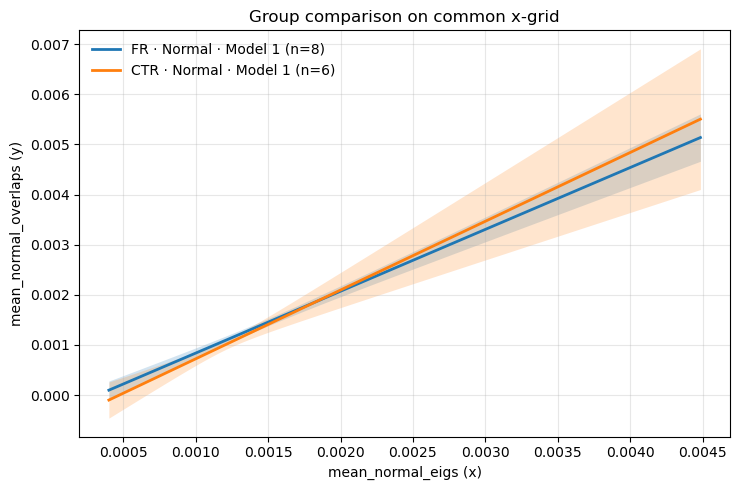

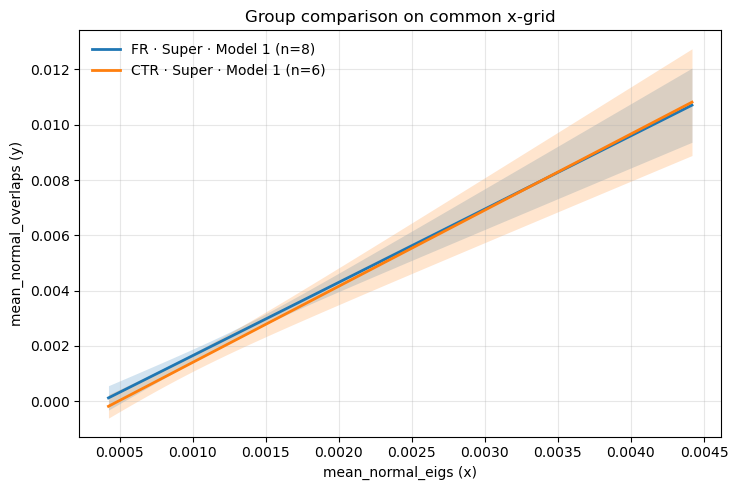

In [33]:
rag_fr = np.load('../Data/overlaps_sated_fr_ragged_7_large.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]
overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_7_large.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str

res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_normal_dict_fr,
         eigs_dict=eigs_normal_dict_fr,
         label="FR · Normal",
         color='C0'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_normal_dict_ctr,
         eigs_dict=eigs_normal_dict_ctr,
         label="CTR · Normal",
         color='C1'),
], mean_axes=(0,1))



res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_super_dict_fr,
         eigs_dict=eigs_super_dict_fr,
         label="FR · Super",
         color='C0'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_super_dict_ctr,
         eigs_dict=eigs_super_dict_ctr,
         label="CTR · Super",
         color='C1'),
], mean_axes=(0,1))


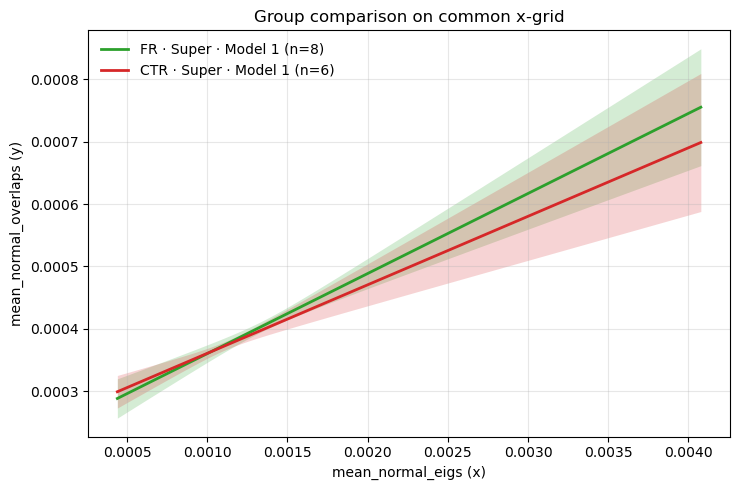

In [11]:
res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_super_dict_fr,
         eigs_dict=eigs_super_dict_fr,
         label="FR · Super",
         color='C2'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_super_dict_ctr,
         eigs_dict=eigs_super_dict_ctr,
         label="CTR · Super",
         color='C3'),
], mean_axes=(0,1))


## Early vs late Line Chart

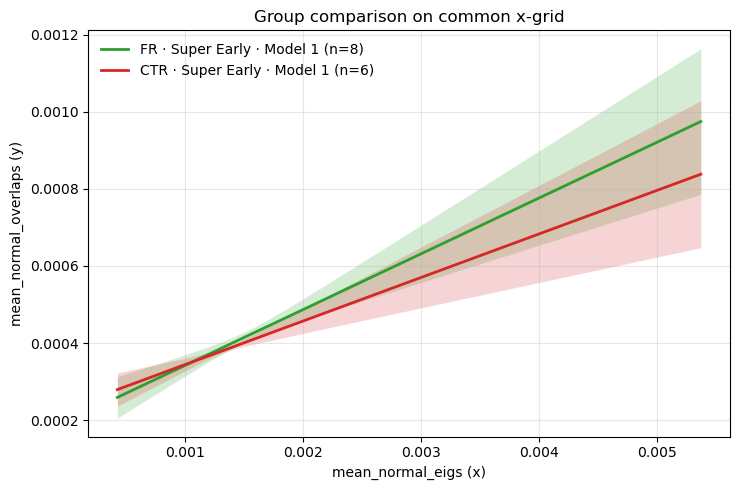

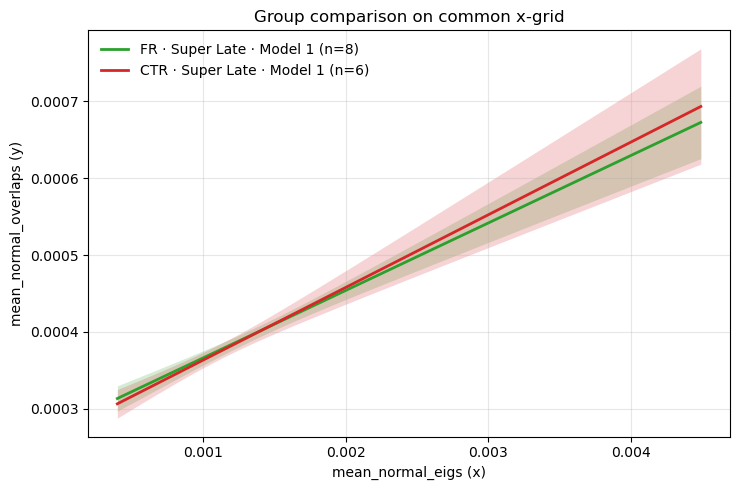

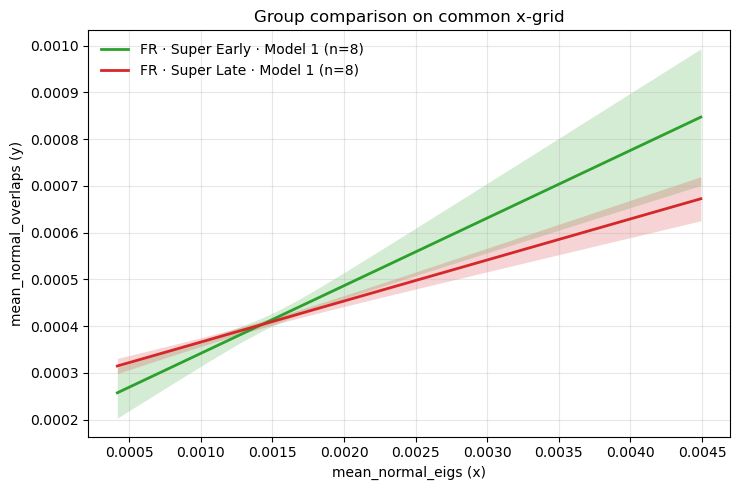

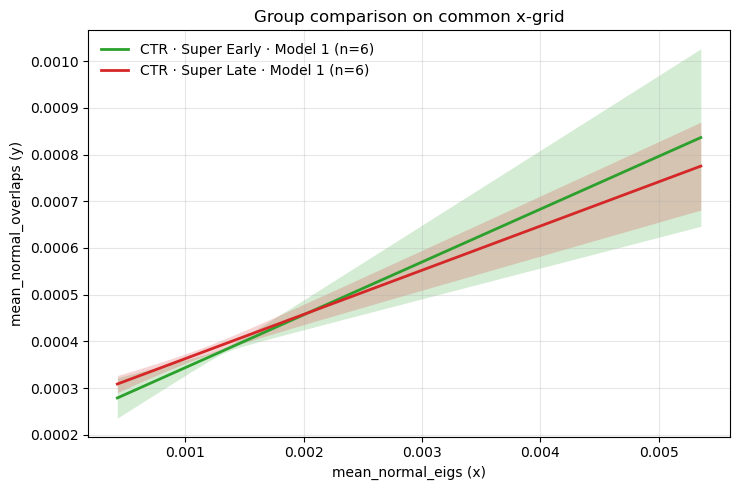

In [12]:
rag_fr = np.load('../Data/overlaps_sated_fr_ragged_3_early.npz', allow_pickle=True)
overlaps_normal_dict_fr_early = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr_early = rag_fr['eigs_normal'].item()  # dict[str->ndarray]
overlaps_super_dict_fr_early = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr_early = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_3_early.npz', allow_pickle=True)
overlaps_normal_dict_ctr_early = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr_early = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr_early = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr_early = rag_ctr['eigs_super'].item()  # dict[str->ndarray]


rag_fr = np.load('../Data/overlaps_sated_fr_ragged_3_late.npz', allow_pickle=True)
overlaps_normal_dict_fr_late = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr_late = rag_fr['eigs_normal'].item()  # dict[str->ndarray]
overlaps_super_dict_fr_late = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr_late = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_3_late.npz', allow_pickle=True)
overlaps_normal_dict_ctr_late = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr_late = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr_late = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr_late = rag_ctr['eigs_super'].item()  # dict[str->ndarray]





res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_super_dict_fr_early,
         eigs_dict=eigs_super_dict_fr_early,
         label="FR · Super Early",
         color='C2'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_super_dict_ctr_early,
         eigs_dict=eigs_super_dict_ctr_early,
         label="CTR · Super Early",
         color='C3'),
], mean_axes=(0,1))
res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_super_dict_fr_late,
         eigs_dict=eigs_super_dict_fr_late,
         label="FR · Super Late",
         color='C2'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_super_dict_ctr_late,
         eigs_dict=eigs_super_dict_ctr_late,
         label="CTR · Super Late",
         color='C3'),
], mean_axes=(0,1))


res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_super_dict_fr_early,
         eigs_dict=eigs_super_dict_fr_early,
         label="FR · Super Early",
         color='C2'),
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_super_dict_fr_late,
         eigs_dict=eigs_super_dict_fr_late,
         label="FR · Super Late",
         color='C3'),
], mean_axes=(0,1))




res = compare_groups_on_common_grid([
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_super_dict_ctr_early,
         eigs_dict=eigs_super_dict_ctr_early,
         label="CTR · Super Early",
         color='C2'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_super_dict_ctr_late,
         eigs_dict=eigs_super_dict_ctr_late,
         label="CTR · Super Late",
         color='C3'),
], mean_axes=(0,1))


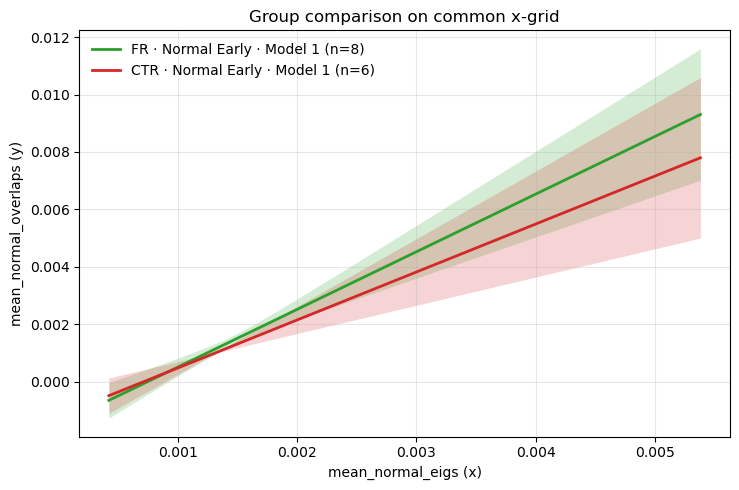

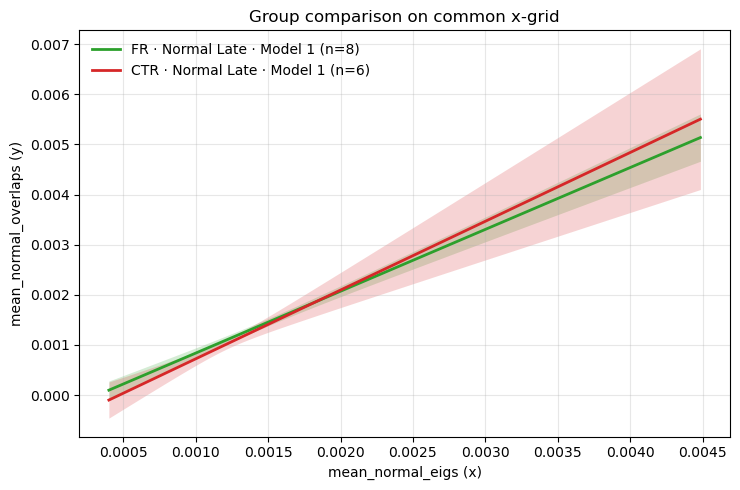

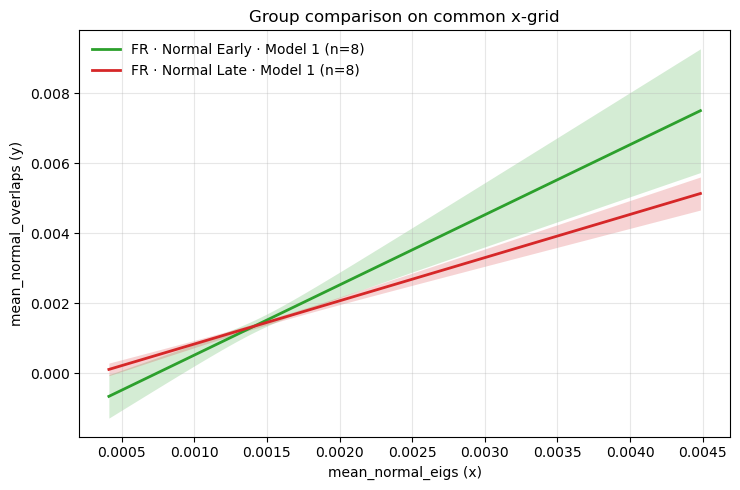

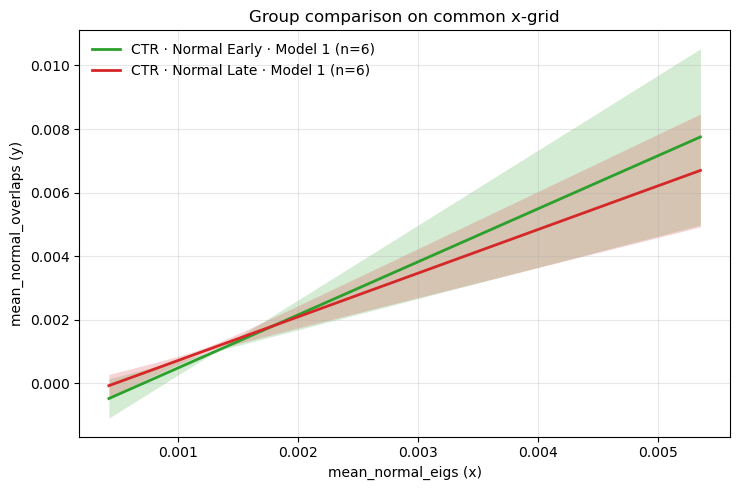

In [13]:
res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_normal_dict_fr_early,
         eigs_dict=eigs_normal_dict_fr_early,
         label="FR · Normal Early",
         color='C2'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_normal_dict_ctr_early,
         eigs_dict=eigs_normal_dict_ctr_early,
         label="CTR · Normal Early",
         color='C3'),
], mean_axes=(0,1))
res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_normal_dict_fr_late,
         eigs_dict=eigs_normal_dict_fr_late,
         label="FR · Normal Late",
         color='C2'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_normal_dict_ctr_late,
         eigs_dict=eigs_normal_dict_ctr_late,
         label="CTR · Normal Late",
         color='C3'),
], mean_axes=(0,1))


res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_normal_dict_fr_early,
         eigs_dict=eigs_normal_dict_fr_early,
         label="FR · Normal Early",
         color='C2'),
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_normal_dict_fr_late,
         eigs_dict=eigs_normal_dict_fr_late,
         label="FR · Normal Late",
         color='C3'),
], mean_axes=(0,1))




res = compare_groups_on_common_grid([
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_normal_dict_ctr_early,
         eigs_dict=eigs_normal_dict_ctr_early,
         label="CTR · Normal Early",
         color='C2'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_normal_dict_ctr_late,
         eigs_dict=eigs_normal_dict_ctr_late,
         label="CTR · Normal Late",
         color='C3'),
], mean_axes=(0,1))


## Early vs Late SNR barchart

(12, 5, 162) (12, 5, 162) (48, 5, 162) (48, 5, 162)
(12, 5, 106) (12, 5, 106) (48, 5, 106) (48, 5, 106)
(12, 5, 114) (12, 5, 114) (48, 5, 114) (48, 5, 114)
(12, 5, 136) (12, 5, 136) (48, 5, 136) (48, 5, 136)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 109) (12, 5, 109) (48, 5, 109) (48, 5, 109)
(12, 5, 235) (12, 5, 235) (48, 5, 235) (48, 5, 235)
(12, 5, 129) (12, 5, 129) (48, 5, 129) (48, 5, 129)
(12, 5, 137) (12, 5, 137) (48, 5, 137) (48, 5, 137)
(12, 5, 112) (12, 5, 112) (48, 5, 112) (48, 5, 112)
(12, 5, 56) (12, 5, 56) (48, 5, 56) (48, 5, 56)
(12, 5, 94) (12, 5, 94) (48, 5, 94) (48, 5, 94)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 134) (12, 5, 134) (48, 5, 134) (48, 5, 134)


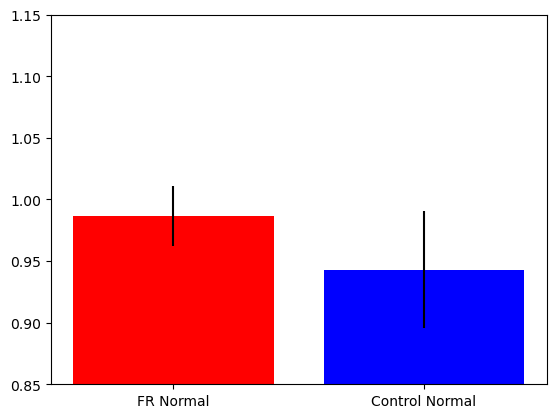

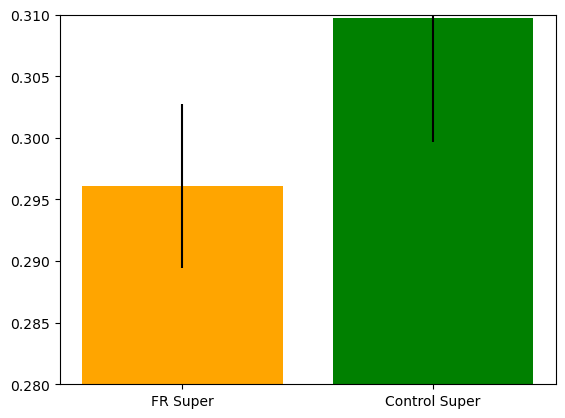

In [14]:
import numpy as np
from types import SimpleNamespace

rag_fr = np.load('../Data/overlaps_sated_fr_ragged_3_late.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_3_late.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str



FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

import matplotlib.pyplot as plt

average_fr_normal = []
average_fr_super = []
for animal in FOOD_RESTRICTED_SATED:
    normal_overlaps = overlaps_normal_dict_fr[animal]
    normal_eigs = eigs_normal_dict_fr[animal]
    super_overlaps = overlaps_super_dict_fr[animal]
    super_eigs = eigs_super_dict_fr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_fr_normal.append(np.nanmean(mean_snr))
    average_fr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)

average_ctr_normal = []
average_ctr_super = []
for animal in CONTROL_SATED:
    normal_overlaps = overlaps_normal_dict_ctr[animal]
    normal_eigs = eigs_normal_dict_ctr[animal]
    super_overlaps = overlaps_super_dict_ctr[animal]
    super_eigs = eigs_super_dict_ctr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_ctr_normal.append(np.nanmean(mean_snr))
    average_ctr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)
plt.bar([0,1], [np.mean(average_fr_normal), np.mean(average_ctr_normal)], yerr=[np.std(average_fr_normal)/np.sqrt(len(average_fr_normal)), np.std(average_ctr_normal)/np.sqrt(len(average_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.15)
plt.show()
plt.bar([0,1], [np.mean(average_fr_super), np.mean(average_ctr_super)], yerr=[np.std(average_fr_super)/np.sqrt(len(average_fr_super)), np.std(average_ctr_super)/np.sqrt(len(average_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.28,0.31)
plt.show()


FR Normal: n=8, mean=0.9867, SEM=0.02597
  Top variance contributor: idx=0, value=1.12
  Contribution to variance: 47.2%
  SEM if dropped: 0.02035  (change: +21.7%)
  ↳ No single value appears to dominate.
Control Normal: n=6, mean=0.9431, SEM=0.05195
  Top variance contributor: idx=0, value=1.147
  Contribution to variance: 51.2%
  SEM if dropped: 0.03949  (change: +24.0%)
  ↳ Error likely dominated by a single value.
FR Super: n=8, mean=0.2961, SEM=0.007136
  Top variance contributor: idx=4, value=0.342
  Contribution to variance: 73.9%
  SEM if dropped: 0.003253  (change: +54.4%)
  ↳ Error likely dominated by a single value.
Control Super: n=6, mean=0.3097, SEM=0.01105
  Top variance contributor: idx=5, value=0.257
  Contribution to variance: 75.9%
  SEM if dropped: 0.004044  (change: +63.4%)
  ↳ Error likely dominated by a single value.


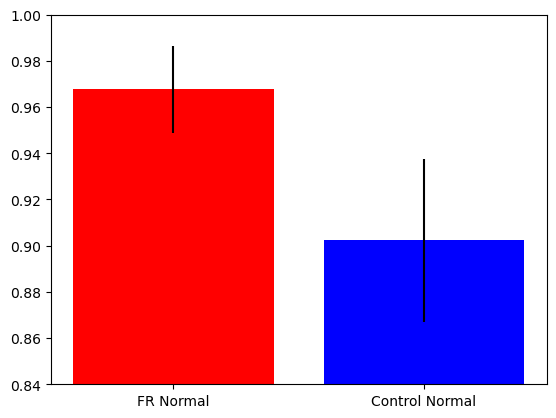

(0.28, 0.35)

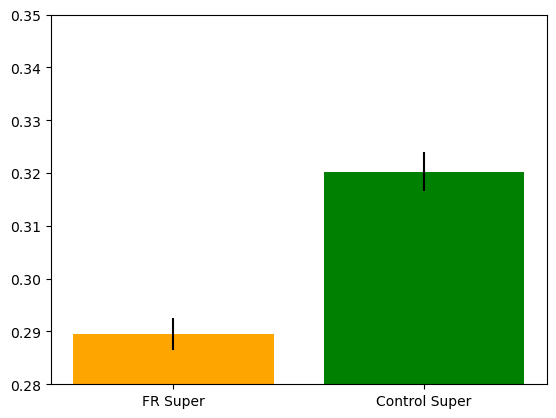

In [15]:
itop_fr_n = sem_influence(average_fr_normal,   "FR Normal")
itop_ctr_n = sem_influence(average_ctr_normal,  "Control Normal")
itop_fr_s = sem_influence(average_fr_super,    "FR Super")
itop_ctr_s = sem_influence(average_ctr_super,   "Control Super")


dropped_fr_normal = [x for i,x in enumerate(average_fr_normal) if i!=itop_fr_n]
dropped_ctr_normal = [x for i,x in enumerate(average_ctr_normal) if i!=itop_ctr_n]
dropped_fr_super = [x for i,x in enumerate(average_fr_super) if i!=itop_fr_s]
dropped_ctr_super = [x for i,x in enumerate(average_ctr_super) if i!=itop_ctr_s]
plt.bar([0,1], [np.mean(dropped_fr_normal), np.mean(dropped_ctr_normal)], yerr=[np.std(dropped_fr_normal)/np.sqrt(len(dropped_fr_normal)), np.std(dropped_ctr_normal)/np.sqrt(len(dropped_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.84,1)
plt.show()
plt.bar([0,1], [np.mean(dropped_fr_super), np.mean(dropped_ctr_super)], yerr=[np.std(dropped_fr_super)/np.sqrt(len(dropped_fr_super)), np.std(dropped_ctr_super)/np.sqrt(len(dropped_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.28,0.35)

## COS overall Line

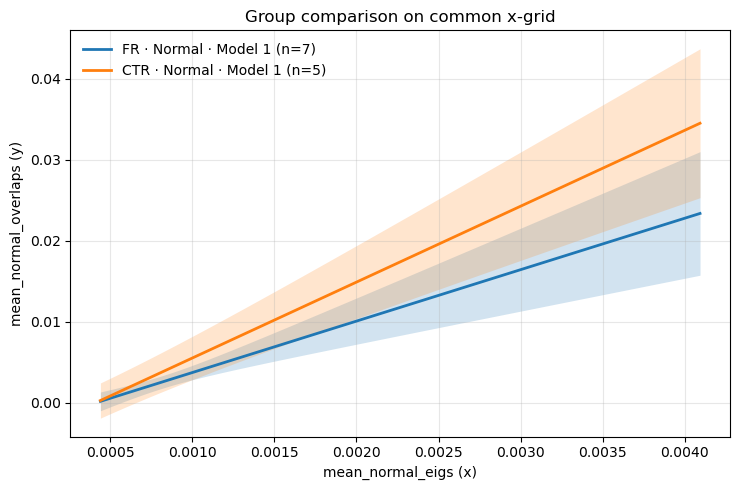

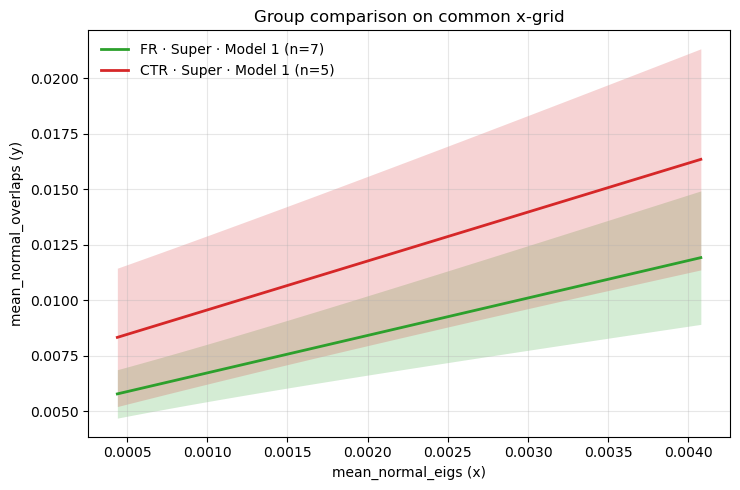

In [21]:
import numpy as np
from types import SimpleNamespace


rag_fr = np.load('../Data/overlaps_sated_fr_ragged_4.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_4.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str->ndarray]


res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED[:-1],
         overlaps_dict=overlaps_normal_dict_fr,
         eigs_dict=eigs_normal_dict_fr,
         label="FR · Normal",
         color='C0'),
    dict(animals=CONTROL_SATED[:-1],
         overlaps_dict=overlaps_normal_dict_ctr,
         eigs_dict=eigs_normal_dict_ctr,
         label="CTR · Normal",
         color='C1'),
], mean_axes=(0,1))

res = compare_groups_on_common_grid([
     dict(animals=FOOD_RESTRICTED_SATED[:-1],
           overlaps_dict=overlaps_super_dict_fr,
           eigs_dict=eigs_super_dict_fr,
           label="FR · Super",
           color='C2'),
     dict(animals=CONTROL_SATED[:-1],
           overlaps_dict=overlaps_super_dict_ctr,
           eigs_dict=eigs_super_dict_ctr,
           label="CTR · Super",
           color='C3'),
], mean_axes=(0,1))


In [ ]:
rag_fr = np.load('../Data/overlaps_sated_fr_ragged_4.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_4.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str->ndarray]


## Cos early vs late line

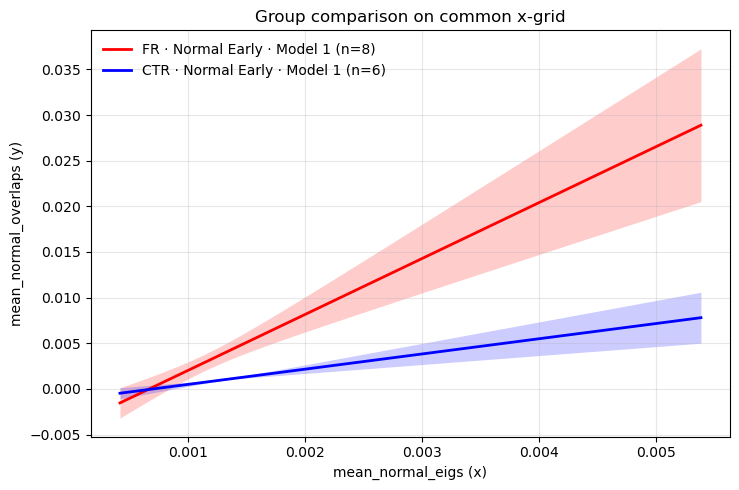

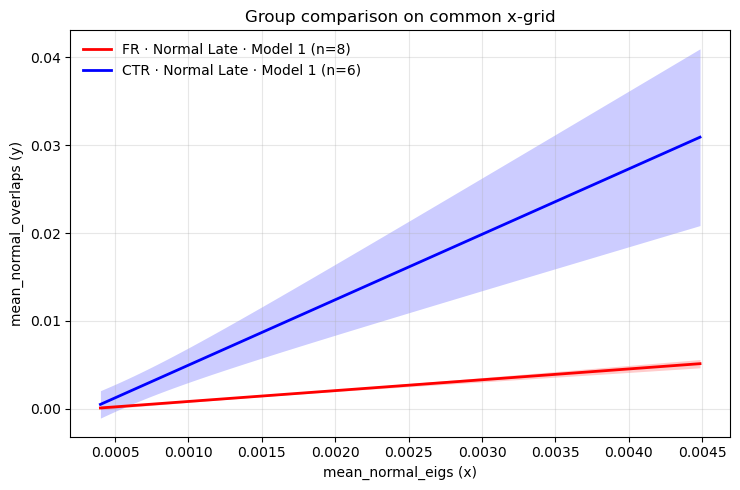

In [95]:
rag_fr_early = np.load('../Data/overlaps_sated_fr_ragged_5_early.npz', allow_pickle=True)
overlaps_normal_dict_fr_early = rag_fr_early['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr_early = rag_fr_early['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr_early = rag_fr_early['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr_early = rag_fr_early['eigs_super'].item()  # dict[str->ndarray]


rag_ctr_late = np.load('../Data/overlaps_sated_ctr_ragged_5_late.npz', allow_pickle=True)
overlaps_normal_dict_ctr_late = rag_ctr_late['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr_late = rag_ctr_late['eigs_normal'].item()
overlaps_super_dict_ctr_late = rag_ctr_late['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr_late = rag_ctr_late['eigs_super'].item()  # dict[str->ndarray]


res = compare_groups_on_common_grid([
     dict(animals=FOOD_RESTRICTED_SATED,
           overlaps_dict=overlaps_normal_dict_fr_early,
           eigs_dict=eigs_normal_dict_fr_early,
           label="FR · Normal Early",
           color='red'),
     dict(animals=CONTROL_SATED,
           overlaps_dict=overlaps_normal_dict_ctr_early,
           eigs_dict=eigs_normal_dict_ctr_early,
           label="CTR · Normal Early",
           color='blue'),
], mean_axes=(0,1))

res = compare_groups_on_common_grid([
     dict(animals=FOOD_RESTRICTED_SATED,
           overlaps_dict=overlaps_normal_dict_fr_late,
           eigs_dict=eigs_normal_dict_fr_late,
           label="FR · Normal Late",
           color='red'),
     dict(animals=CONTROL_SATED,
           overlaps_dict=overlaps_normal_dict_ctr_late,
           eigs_dict=eigs_normal_dict_ctr_late,
           label="CTR · Normal Late",
           color='blue'),
], mean_axes=(0,1))


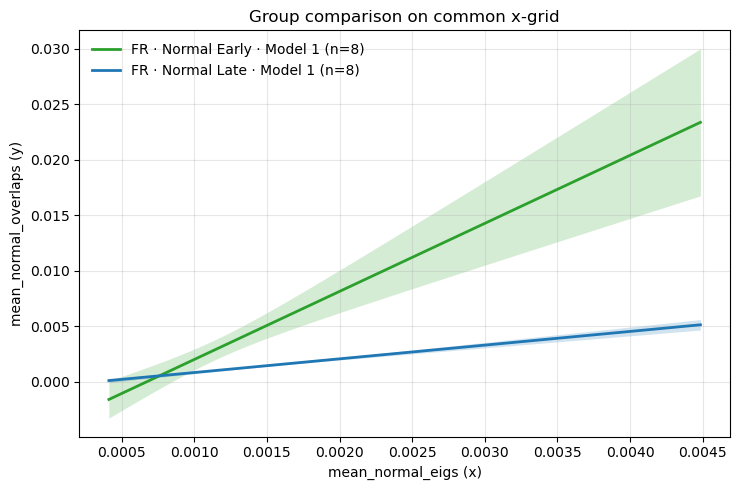

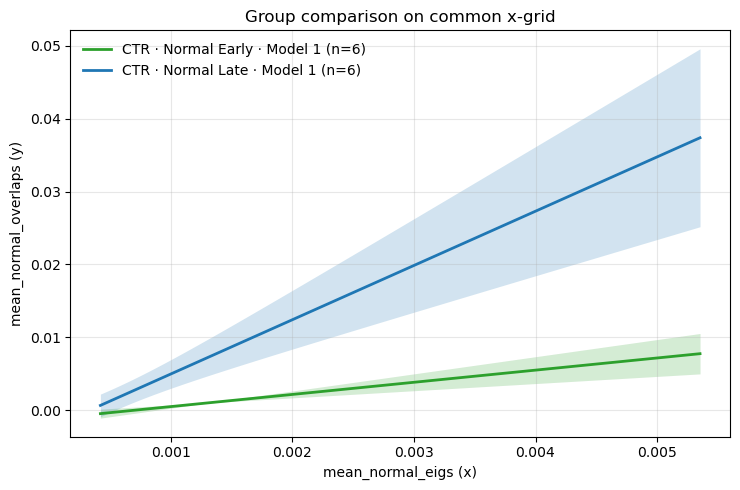

In [93]:
res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_normal_dict_fr_early,
         eigs_dict=eigs_normal_dict_fr_early,
         label="FR · Normal Early",
         color='C2'),
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_normal_dict_fr_late,
         eigs_dict=eigs_normal_dict_fr_late,
         label="FR · Normal Late",
         color='C0'),
], mean_axes=(0,1))

res = compare_groups_on_common_grid([
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_normal_dict_ctr_early,
         eigs_dict=eigs_normal_dict_ctr_early,
         label="CTR · Normal Early",
         color='C2'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_normal_dict_ctr_late,
         eigs_dict=eigs_normal_dict_ctr_late,
         label="CTR · Normal Late",
         color='C0'),
], mean_axes=(0,1))

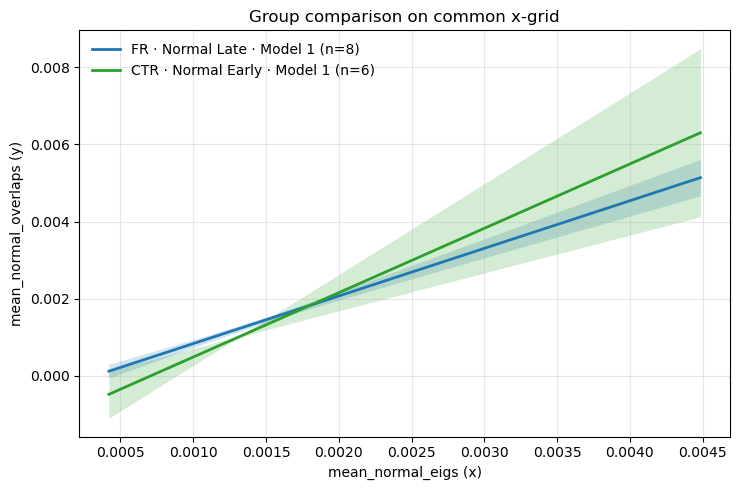

In [94]:
res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_normal_dict_fr_late,
         eigs_dict=eigs_normal_dict_fr_late,
         label="FR · Normal Late",
         color='C0'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_normal_dict_ctr_early,
         eigs_dict=eigs_normal_dict_ctr_early,
         label="CTR · Normal Early",
         color='C2'),
], mean_axes=(0,1))

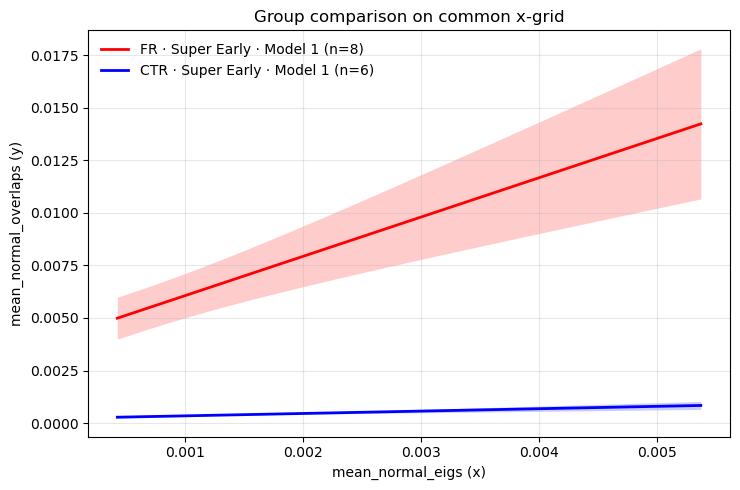

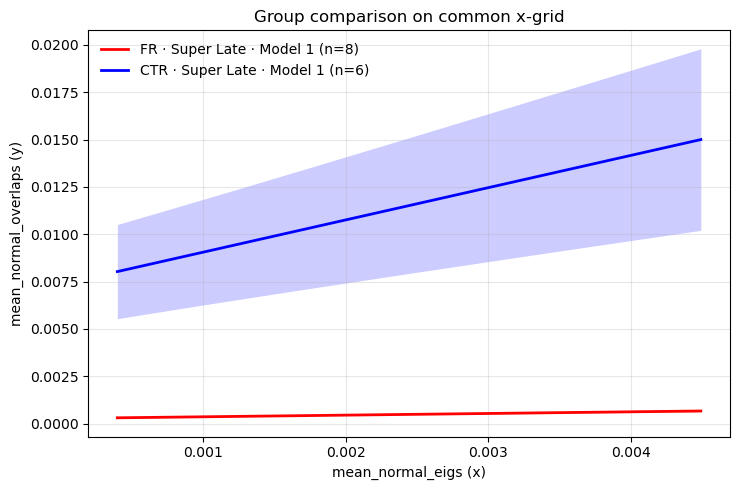

In [96]:
res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_super_dict_fr_early,
         eigs_dict=eigs_super_dict_fr_early,
         label="FR · Super Early",
         color='red'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_super_dict_ctr_early,
         eigs_dict=eigs_super_dict_ctr_early,
         label="CTR · Super Early",
         color='blue'),
], mean_axes=(0,1))

res = compare_groups_on_common_grid([
    dict(animals=FOOD_RESTRICTED_SATED,
         overlaps_dict=overlaps_super_dict_fr_late,
         eigs_dict=eigs_super_dict_fr_late,
         label="FR · Super Late",
         color='red'),
    dict(animals=CONTROL_SATED,
         overlaps_dict=overlaps_super_dict_ctr_late,
         eigs_dict=eigs_super_dict_ctr_late,
         label="CTR · Super Late",
         color='blue'),
], mean_axes=(0,1))


In [8]:
import numpy as np
conditions_array = np.linspace(4,90,20).astype('int')
C =12
for condition in conditions_array:
    X_TEST_CONDITIONS = np.linspace(0, C-1, condition)
    print(X_TEST_CONDITIONS)
    break

[ 0.          3.66666667  7.33333333 11.        ]


# New Analysis

In [50]:
data = np.load('snr_results_sated_full.npz')
snr_outputs_mean_fr_full = data['snr_outputs_mean_fr_full']
snr_outputs_mean_ctr_full = data['snr_outputs_mean_ctr_full']
# snr_outputs_mean_fr_early = data['snr_outputs_mean_fr_early']
# snr_outputs_mean_ctr_early = data['snr_outputs_mean_ctr_early']
# snr_outputs_mean_fr_late = data['snr_outputs_mean_fr_late']
# snr_outputs_mean_ctr_late = data['snr_outputs_mean_ctr_late']


ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

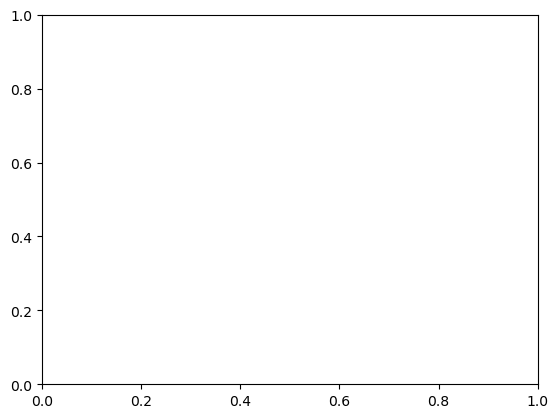

In [21]:
from scipy.stats import norm
cdf_probability = norm.cdf((np.sqrt(snr_outputs_mean_fr_full)/2))
plt.plot(360/np.linspace(4,90,10).astype('int'),np.nanmean(cdf_probability, axis= 0), color = 'red')

cdf_probability = norm.cdf((np.sqrt(snr_outputs_mean_ctr_full)/2))
plt.plot(360/np.linspace(4,90,10).astype('int'),np.nanmean(cdf_probability, axis= 0), color = 'blue')
plt.xlim(0,30)

ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

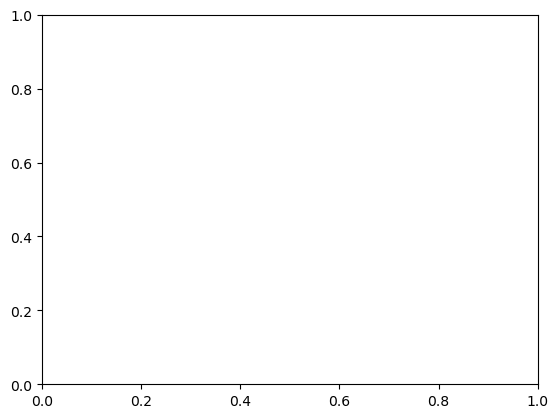

In [22]:
from matplotlib import pyplot as plt
import numpy as np
# snr_outputs_mean_fr_full = snr_outputs_mean_fr_full[:-1,:]
# snr_outputs_mean_ctr_full = snr_outputs_mean_ctr_full[:-1,:]
fr_full_mean = np.nanmean(snr_outputs_mean_fr_full, axis=0)
fr_full_sem = np.nanstd(snr_outputs_mean_fr_full, axis=0)/np.sqrt(snr_outputs_mean_fr_full.shape[0])
ctr_full_mean = np.nanmean(snr_outputs_mean_ctr_full, axis=0)
ctr_full_sem = np.nanstd(snr_outputs_mean_ctr_full, axis=0)/np.sqrt(snr_outputs_mean_ctr_full.shape[0])
plt.plot(360/np.linspace(4,90,10).astype('int'), fr_full_mean, color='red', label='FR Full')
plt.fill_between(360/np.linspace(4,90,10).astype('int'), fr_full_mean-fr_full_sem, fr_full_mean+fr_full_sem, color='red', alpha=0.3)
plt.plot(360/np.linspace(4,90,10).astype('int'), ctr_full_mean, color='blue', label='Control Full')
plt.fill_between(360/np.linspace(4,90,10).astype('int'), ctr_full_mean-ctr_full_sem, ctr_full_mean+ctr_full_sem, color='blue', alpha=0.3)
# plt.xlim(4,15)
# plt.ylim(.2,.4)
plt.xlabel('Angle difference (degrees)')
plt.ylabel('SNR')

In [ ]:
data = np.load('snr_results_sated_full_2.npz')
snr_outputs_mean_fr_full = data['snr_outputs_mean_fr_full'][:-1,:]
snr_outputs_mean_ctr_full = data['snr_outputs_mean_ctr_full'][:-1,:]
snr_outputs_mean_fr_early = data['snr_outputs_mean_fr_early']
snr_outputs_mean_ctr_early = data['snr_outputs_mean_ctr_early']
snr_outputs_mean_fr_late = data['snr_outputs_mean_fr_late']
snr_outputs_mean_ctr_late = data['snr_outputs_mean_ctr_late']
snr_outputs_mean_fr_full = norm.cdf((np.sqrt(snr_outputs_mean_fr_full)/2))
snr_outputs_mean_ctr_full = norm.cdf((np.sqrt(snr_outputs_mean_ctr_full)/2))

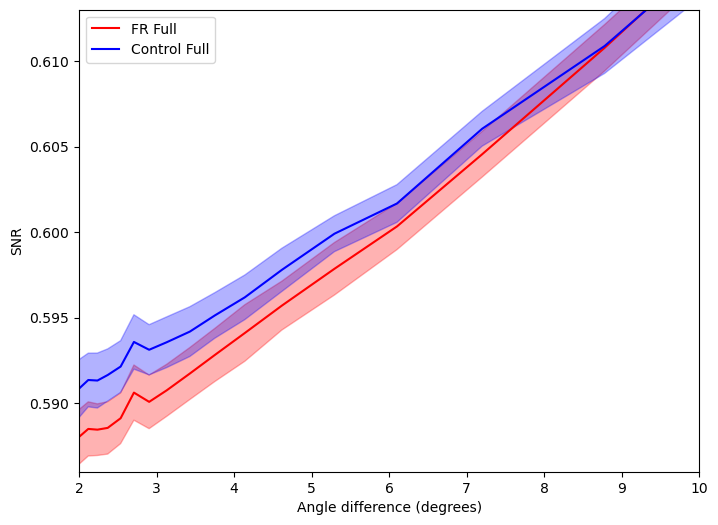

In [35]:
# from matplotlib import pyplot as plt
# import numpy as np
plt.figure(figsize=(8,6))



fr_full_mean = np.nanmean(snr_outputs_mean_fr_full, axis=0)
fr_full_sem = np.nanstd(snr_outputs_mean_fr_full, axis=0)/np.sqrt(snr_outputs_mean_fr_full.shape[0])
ctr_full_mean = np.nanmean(snr_outputs_mean_ctr_full, axis=0)
ctr_full_sem = np.nanstd(snr_outputs_mean_ctr_full, axis=0)/np.sqrt(snr_outputs_mean_ctr_full.shape[0])
plt.plot(360/np.linspace(4,180,20).astype('int'), fr_full_mean, color='red', label='FR Full')
plt.fill_between(360/np.linspace(4,180,20).astype('int'), fr_full_mean-fr_full_sem, fr_full_mean+fr_full_sem, color='red', alpha=0.3)
plt.plot(360/np.linspace(4,180,20).astype('int'), ctr_full_mean, color='blue', label='Control Full')
plt.fill_between(360/np.linspace(4,180,20).astype('int'), ctr_full_mean-ctr_full_sem, ctr_full_mean+ctr_full_sem, color='blue', alpha=0.3)
plt.xlim(2,10)
plt.ylim(.586,.613)
plt.xlabel('Angle difference (degrees)')
plt.ylabel('SNR')


# fr_early_mean = np.nanmean(snr_outputs_mean_fr_early, axis=0)
# fr_early_sem = np.nanstd(snr_outputs_mean_fr_early, axis=0)/np.sqrt(snr_outputs_mean_fr_early.shape[0])
# ctr_early_mean = np.nanmean(snr_outputs_mean_ctr_early, axis=0)
# ctr_early_sem = np.std(snr_outputs_mean_ctr_early, axis=0)/np.sqrt(snr_outputs_mean_ctr_early.shape[0])
# # plt.plot(360/np.linspace(4,180,20).astype('int'), fr_early_mean, color='orange', label='FR Early')
# # plt.fill_between(360/np.linspace(4,180,20).astype('int'), fr_early_mean-fr_early_sem, fr_early_mean+fr_early_sem, color='orange', alpha=0.3)
# plt.plot(360/np.linspace(4,180,20).astype('int'), ctr_early_mean, color='cyan', label='Control Early')
# # plt.fill_between(360/np.linspace(4,180,20).astype('int'), ctr_early_mean-ctr_early_sem, ctr_early_mean+ctr_early_sem, color='cyan', alpha=0.3)



# fr_late_mean = np.nanmean(snr_outputs_mean_fr_late, axis=0)
# fr_late_sem = np.nanstd(snr_outputs_mean_fr_late, axis=0)/np.sqrt(snr_outputs_mean_fr_late.shape[0])
# ctr_late_mean = np.nanmean(snr_outputs_mean_ctr_late, axis=0)
# ctr_late_sem = np.std(snr_outputs_mean_ctr_late, axis=0)/np.sqrt(snr_outputs_mean_ctr_late.shape[0])
# # plt.plot(360/np.linspace(4,180,20).astype('int'), fr_late_mean, color='darkred', label='FR Late')
# # plt.fill_between(360/np.linspace(4,180,20).astype('int'), fr_late_mean-fr_late_sem, fr_late_mean+fr_late_sem, color='darkred', alpha=0.3)
# plt.plot(360/np.linspace(4,180,20).astype('int'), ctr_late_mean, color='darkblue', label='Control Late')
# # plt.fill_between(360/np.linspace(4,180,20).astype('int'), ctr_late_mean-ctr_late_sem, ctr_late_mean+ctr_late_sem, color='darkblue', alpha=0.3)
plt.legend()
# plt.xlim(2,15)
# plt.ylim(0.16,.4)
plt.show()

In [12]:
# Top 10 e vals vs bottom
import numpy as np
import matplotlib.pyplot as plt
rag_fr = np.load('../Data/overlaps_sated_fr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str



FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

import matplotlib.pyplot as plt
average_fr_normal = []
average_fr_normal_bottom = []
average_fr_super_top = []
average_fr_super = []

for animal in FOOD_RESTRICTED_SATED:
    normal_overlaps = overlaps_normal_dict_fr[animal]
    normal_eigs = eigs_normal_dict_fr[animal]
    super_overlaps = overlaps_super_dict_fr[animal]
    super_eigs = eigs_super_dict_fr[animal]
    snr = normal_overlaps/normal_eigs
    print(snr.shape)
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))
    top_snr = mean_snr[:10]
    bottom_snr = mean_snr[10:]
    average_fr_normal_bottom.append(np.nanmean(bottom_snr))
    # top_snr_super = mean_snr_super[-10:]

    average_fr_normal.append((mean_snr))
    average_fr_super.append(np.nanmean(mean_snr_super))
    # print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)

average_ctr_normal = []
average_ctr_normal_top = []
average_ctr_normal_bottom= []
average_ctr_super = []
for animal in CONTROL_SATED:
    normal_overlaps = overlaps_normal_dict_ctr[animal]
    normal_eigs = eigs_normal_dict_ctr[animal]
    super_overlaps = overlaps_super_dict_ctr[animal]
    super_eigs = eigs_super_dict_ctr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))
    top_snr = mean_snr[:10]
    bottom_snr = mean_snr[10:]
    average_ctr_normal_top.append(np.nanmean(top_snr))
    average_ctr_normal_bottom.append(np.nanmean(bottom_snr))
    

    average_ctr_normal.append((mean_snr))
    average_ctr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)
plt.bar([0,1], [np.mean(average_fr_normal), np.mean(average_ctr_normal)], yerr=[np.std(average_fr_normal)/np.sqrt(len(average_fr_normal)), np.std(average_ctr_normal)/np.sqrt(len(average_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.15)
plt.show()
plt.bar([0,1], [np.mean(average_fr_super), np.mean(average_ctr_super)], yerr=[np.std(average_fr_super)/np.sqrt(len(average_fr_super)), np.std(average_ctr_super)/np.sqrt(len(average_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.29,0.33)
plt.show()
plt.bar([0,1,2,3], [np.mean(average_fr_normal_bottom), np.mean(average_fr_normal), np.mean(average_ctr_normal_bottom), np.mean(average_ctr_normal)], yerr=[np.std(average_fr_normal_bottom)/np.sqrt(len(average_fr_normal_bottom)), np.std(average_fr_normal)/np.sqrt(len(average_fr_normal)), np.std(average_ctr_normal_bottom)/np.sqrt(len(average_ctr_normal_bottom)), np.std(average_ctr_normal)/np.sqrt(len(average_ctr_normal))], tick_label=['FR top 10', 'FR rest', 'Control top 10', 'Control rest'], color=['darkred', 'red', 'darkblue', 'blue']  )
plt.ylim(0.9,1.1)


(12, 5, 162)
(12, 5, 106)
(12, 5, 114)
(12, 5, 136)
(12, 5, 104)
(12, 5, 109)
(12, 5, 235)
(12, 5, 129)
(12, 5, 137) (12, 5, 137) (48, 5, 137) (48, 5, 137)
(12, 5, 112) (12, 5, 112) (48, 5, 112) (48, 5, 112)
(12, 5, 56) (12, 5, 56) (48, 5, 56) (48, 5, 56)
(12, 5, 94) (12, 5, 94) (48, 5, 94) (48, 5, 94)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 134) (12, 5, 134) (48, 5, 134) (48, 5, 134)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8,) + inhomogeneous part.

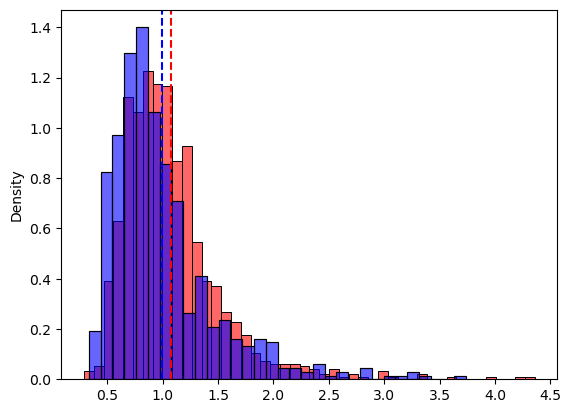

In [19]:
import seaborn as sns
sns.histplot(np.concatenate(average_fr_normal), color='red', label='FR Normal', alpha = 0.6, stat = 'density')
sns.histplot(np.concatenate(average_ctr_normal), color='blue', label='Control Normal', alpha = 0.6, stat = 'density')
plt.axvline(np.mean(np.concatenate(average_fr_normal)), color='red', linestyle='--')
plt.axvline(np.mean(np.concatenate(average_ctr_normal)), color='blue', linestyle='--')

# All SFS

In [ ]:
from scipy.stats import norm
import numpy as np
# data = np.load('snr_results_sated_full_4_sf_actual.npz')
data = np.load('snr_results_sated_full_3_sf.npz')
snr_outputs_mean_fr_full = data['snr_outputs_mean_fr_full'][:-1,:,:]
snr_outputs_mean_ctr_full = data['snr_outputs_mean_ctr_full'][:-1,:,:]
snr_outputs_mean_fr_early = data['snr_outputs_mean_fr_early']
snr_outputs_mean_ctr_early = data['snr_outputs_mean_ctr_early']
snr_outputs_mean_fr_late = data['snr_outputs_mean_fr_late']
snr_outputs_mean_ctr_late = data['snr_outputs_mean_ctr_late']
# N = 1
# snr_outputs_mean_fr_full = norm.cdf((np.sqrt(N*snr_outputs_mean_fr_full)/2))
# snr_outputs_mean_ctr_full = norm.cdf((np.sqrt(N*snr_outputs_mean_ctr_full)/2))




Text(0, 0.5, 'SNR')

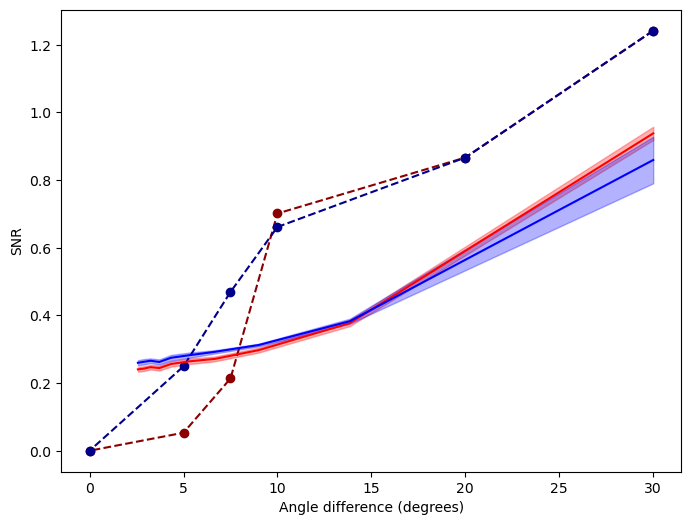

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
plt.figure(figsize=(8,6))
    

x_vals = [30,20,10,7.5,5,0]
fr_behaviour = [.81,.73,.69,.56,.515,.5]
ctr_behaviour = [.81,.73,.68,.63,.57,.5]
fr_snr_equiv = norm.ppf(fr_behaviour)*np.sqrt(2)
ctr_snr_equiv = norm.ppf(ctr_behaviour)*np.sqrt(2)
plt.plot(x_vals, fr_snr_equiv, 'o--', color='darkred', label='FR Behaviour')
plt.plot(x_vals, ctr_snr_equiv, 'o--', color='darkblue', label='Control Behaviour')
# fr_snr = [1.747,0.679,0.550,0.026,0.000,0.000]
# ctr_snr = [1.747,0.751,0.492,0.363,0.072,0.000]
# plt.plot(x_vals, fr_snr, 'o-', color='red', label='FR Full')
# plt.plot(x_vals, ctr_snr, 'o-', color='blue', label='Control Full')

conditions_array = np.linspace(12,140,10).astype('int')

plot_ctr =np.nanmean(snr_outputs_mean_ctr_full, axis=1)
plot_fr = np.nanmean(snr_outputs_mean_fr_full, axis=1)


fr_full_mean = np.nanmean(plot_fr, axis=0)
fr_full_sem = np.nanstd(plot_fr, axis=0)/np.sqrt(plot_fr.shape[0])
ctr_full_mean = np.nanmean(plot_ctr, axis=0)
ctr_full_sem = np.nanstd(plot_ctr, axis=0)/np.sqrt(plot_ctr.shape[0])
plt.plot(360/conditions_array, fr_full_mean, color='red', label='FR Full')
plt.fill_between(360/conditions_array, fr_full_mean-fr_full_sem, fr_full_mean+fr_full_sem, color='red', alpha=0.3)
plt.plot(360/conditions_array, ctr_full_mean, color='blue', label='Control Full')
plt.fill_between(360/conditions_array, ctr_full_mean-ctr_full_sem, ctr_full_mean+ctr_full_sem, color='blue', alpha=0.3)
# plt.xlim(2,10)
# plt.ylim(.586,.613)
plt.xlabel('Angle difference (degrees)')
plt.ylabel('SNR/N')

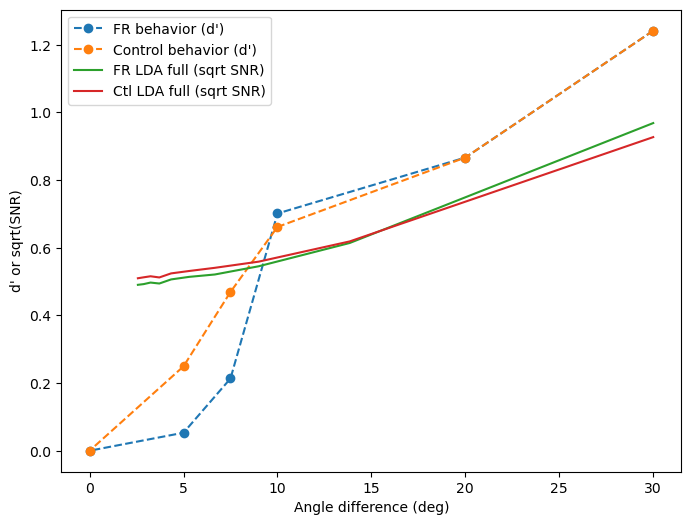

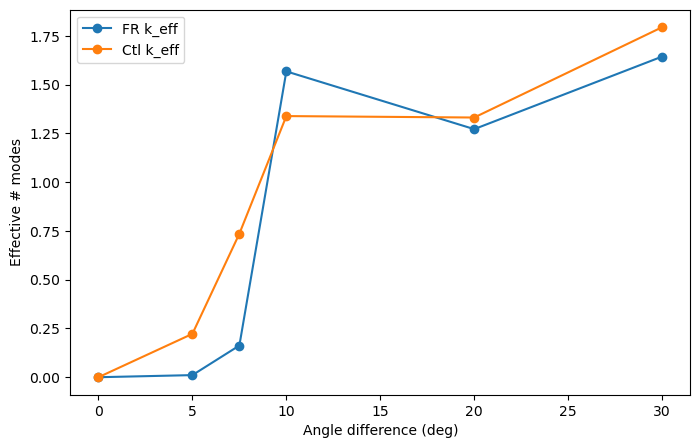

In [12]:
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# --- your inputs ---
x_behav = np.array([30,20,10,7.5,5,0], dtype=float)
fr_behaviour = np.array([.81,.73,.69,.56,.515,.5], dtype=float)
ctr_behaviour = np.array([.81,.73,.68,.63,.57,.5], dtype=float)

# Neural SNR "full" curves you already computed
angles_lda = 360/conditions_array.astype(float)             # x for LDA curves (degrees)
fr_full_mean = np.asarray(fr_full_mean, dtype=float)        # SNR_full(FR) at angles_lda
ctr_full_mean = np.asarray(ctr_full_mean, dtype=float)      # SNR_full(Ctl) at angles_lda

# --- 1) Behavior -> SNR (d'^2) ---
fr_dprime = np.sqrt(2.0) * norm.ppf(fr_behaviour.clip(1e-4, 1-1e-4))
ctr_dprime = np.sqrt(2.0) * norm.ppf(ctr_behaviour.clip(1e-4, 1-1e-4))
fr_snr_behav = fr_dprime**2
ctr_snr_behav = ctr_dprime**2

# --- 2) Interpolate LDA SNR_full onto behavioral x ---
# (remove any zero/duplicate angles and sort for safe interpolation)
mask = np.isfinite(angles_lda) & np.isfinite(fr_full_mean) & np.isfinite(ctr_full_mean) & (angles_lda>0)
ix = np.argsort(angles_lda[mask])
ang_sorted = angles_lda[mask][ix]
fr_sorted = fr_full_mean[mask][ix]
ctr_sorted = ctr_full_mean[mask][ix]

fr_full_interp = interp1d(ang_sorted, fr_sorted, kind='linear', fill_value='extrapolate', bounds_error=False)
ctr_full_interp = interp1d(ang_sorted, ctr_sorted, kind='linear', fill_value='extrapolate', bounds_error=False)

fr_snr_full_at_behav = fr_full_interp(x_behav)
ctr_snr_full_at_behav = ctr_full_interp(x_behav)

# --- 3) Effective number of modes ---
N_modes = 1  # <-- set this!
fr_k_eff = N_modes * (fr_snr_behav / fr_snr_full_at_behav)
ctr_k_eff = N_modes * (ctr_snr_behav / ctr_snr_full_at_behav)

# --- Plot everything aligned ---
plt.figure(figsize=(8,6))
# Behavior d' (for intuition)
plt.plot(x_behav, fr_dprime, 'o--', label='FR behavior (d\')')
plt.plot(x_behav, ctr_dprime, 'o--', label='Control behavior (d\')')
# LDA SNR full (convert to d\' by sqrt if you want to overlay on the same axis)
plt.plot(angles_lda, np.sqrt(fr_full_mean), '-', label='FR LDA full (sqrt SNR)')
plt.plot(angles_lda, np.sqrt(ctr_full_mean), '-', label='Ctl LDA full (sqrt SNR)')
plt.xlabel('Angle difference (deg)')
plt.ylabel('d\' or sqrt(SNR)')
plt.legend()
plt.show()

# Effective modes vs angle
plt.figure(figsize=(8,5))
plt.plot(x_behav, fr_k_eff, 'o-', label='FR k_eff')
plt.plot(x_behav, ctr_k_eff, 'o-', label='Ctl k_eff')
plt.xlabel('Angle difference (deg)')
plt.ylabel('Effective # modes')
plt.legend()
plt.show()


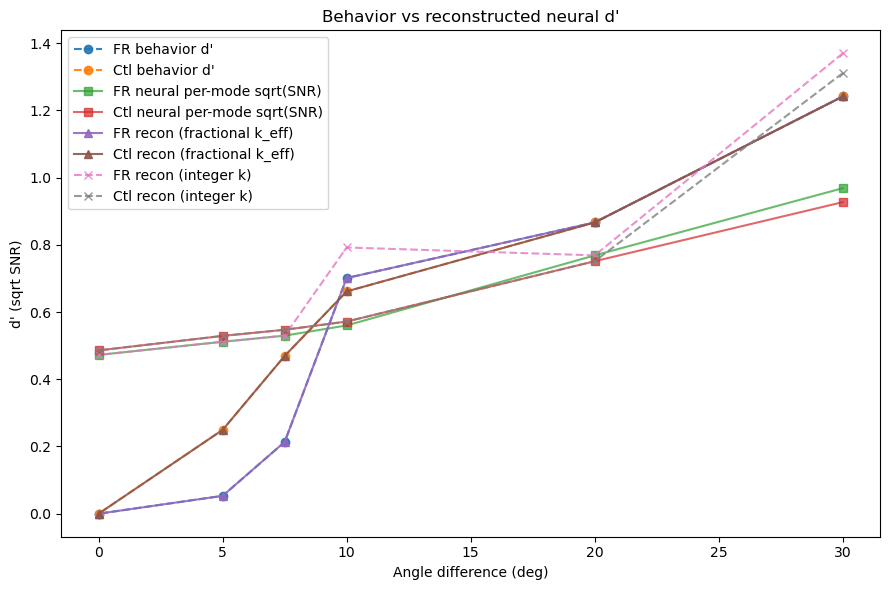

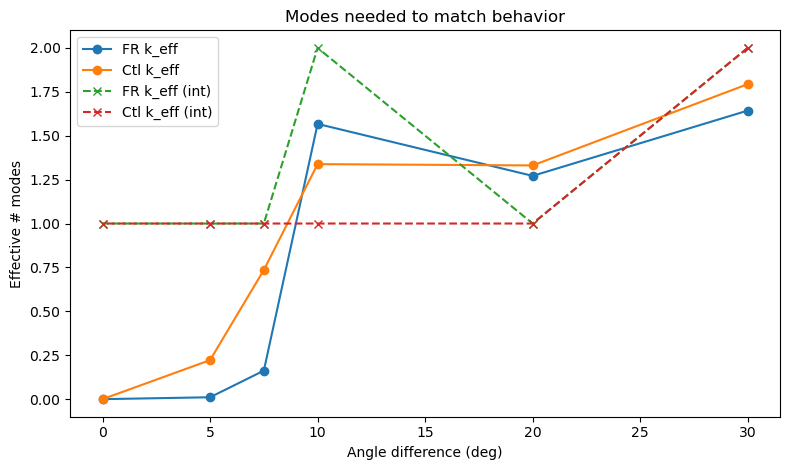

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

# --- Behavior inputs (yours) ---
x_behav = np.array([30,20,10,7.5,5,0], dtype=float)
fr_behaviour = np.array([.81,.73,.69,.56,.515,.5], dtype=float)
ctr_behaviour = np.array([.81,.73,.68,.63,.57,.5], dtype=float)

# Convert behavior to d' and SNR (= d'^2)
fr_dprime = np.sqrt(2.0) * norm.ppf(fr_behaviour.clip(1e-4, 1-1e-4))
ctr_dprime = np.sqrt(2.0) * norm.ppf(ctr_behaviour.clip(1e-4, 1-1e-4))
fr_snr_behav = fr_dprime**2
ctr_snr_behav = ctr_dprime**2

# --- Neural per-mode SNR ("SNR/N") on its own x (yours) ---
angles_lda = 360/conditions_array.astype(float)        # your existing x for neural
fr_full_mean_permode = np.asarray(fr_full_mean, dtype=float)  # FR SNR/N
ctr_full_mean_permode = np.asarray(ctr_full_mean, dtype=float) # Ctl SNR/N

# Interpolate per-mode SNR onto behavior x-grid
mask = np.isfinite(angles_lda) & np.isfinite(fr_full_mean_permode) & np.isfinite(ctr_full_mean_permode) & (angles_lda>0)
ix = np.argsort(angles_lda[mask])
ang_sorted = angles_lda[mask][ix]
fr_sorted = fr_full_mean_permode[mask][ix]
ctr_sorted = ctr_full_mean_permode[mask][ix]

fr_perm_interp = interp1d(ang_sorted, fr_sorted, kind='linear', fill_value='extrapolate', bounds_error=False)
ctr_perm_interp = interp1d(ang_sorted, ctr_sorted, kind='linear', fill_value='extrapolate', bounds_error=False)

fr_perm_at_behav = fr_perm_interp(x_behav)
ctr_perm_at_behav = ctr_perm_interp(x_behav)

# --- Effective # of modes (since data are SNR/N, N_modes=1) ---
# k_eff = SNR_behav / (SNR_per_mode)
fr_k_eff = fr_snr_behav / fr_perm_at_behav
ctr_k_eff = ctr_snr_behav / ctr_perm_at_behav

# Optional: integer-rounded versions (to see effect of a hard k bottleneck)
fr_k_eff_int = np.maximum(1, np.round(fr_k_eff)).astype(int)
ctr_k_eff_int = np.maximum(1, np.round(ctr_k_eff)).astype(int)

# --- Reconstruct neural d' curves from per-mode SNR using k_eff ---
# fractional k: d'_recon = sqrt(k_eff * SNR_per_mode)
fr_dprime_recon_frac = np.sqrt(fr_k_eff * fr_perm_at_behav)
ctr_dprime_recon_frac = np.sqrt(ctr_k_eff * ctr_perm_at_behav)

# integer-rounded k: d'_recon_int = sqrt(k_int * SNR_per_mode)
fr_dprime_recon_int = np.sqrt(fr_k_eff_int * fr_perm_at_behav)
ctr_dprime_recon_int = np.sqrt(ctr_k_eff_int * ctr_perm_at_behav)

# --- PLOTS ---
plt.figure(figsize=(9,6))
# Behavior (ground truth)
plt.plot(x_behav, fr_dprime, 'o--', label="FR behavior d'", alpha=0.9)
plt.plot(x_behav, ctr_dprime, 'o--', label="Ctl behavior d'", alpha=0.9)

# Per-mode neural (for reference): this is what 1 mode would give
plt.plot(x_behav, np.sqrt(fr_perm_at_behav), 's-', label='FR neural per-mode sqrt(SNR)', alpha=0.7)
plt.plot(x_behav, np.sqrt(ctr_perm_at_behav), 's-', label='Ctl neural per-mode sqrt(SNR)', alpha=0.7)

# Reconstructed from neural using k_eff
plt.plot(x_behav, fr_dprime_recon_frac, '^-', label="FR recon (fractional k_eff)", alpha=0.9)
plt.plot(x_behav, ctr_dprime_recon_frac, '^-', label="Ctl recon (fractional k_eff)", alpha=0.9)

# Also show integer-rounded reconstructions (optional)
plt.plot(x_behav, fr_dprime_recon_int, 'x--', label='FR recon (integer k)', alpha=0.8)
plt.plot(x_behav, ctr_dprime_recon_int, 'x--', label='Ctl recon (integer k)', alpha=0.8)

plt.xlabel('Angle difference (deg)')
plt.ylabel("d' (sqrt SNR)")
plt.title("Behavior vs reconstructed neural d'")
plt.legend()
plt.tight_layout()
plt.show()

# Effective # modes panel
plt.figure(figsize=(8,4.8))
plt.plot(x_behav, fr_k_eff, 'o-', label='FR k_eff')
plt.plot(x_behav, ctr_k_eff, 'o-', label='Ctl k_eff')
plt.plot(x_behav, fr_k_eff_int, 'x--', label='FR k_eff (int)')
plt.plot(x_behav, ctr_k_eff_int, 'x--', label='Ctl k_eff (int)')
plt.xlabel('Angle difference (deg)')
plt.ylabel('Effective # modes')
plt.title('Modes needed to match behavior')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
print(360/np.array([30,20,10,7.5,5,0]))

[12. 18. 36. 48. 72. inf]


/tmp/ipykernel_512080/1555474348.py:1: RuntimeWarning: divide by zero encountered in divide
  print(360/np.array([30,20,10,7.5,5,0]))


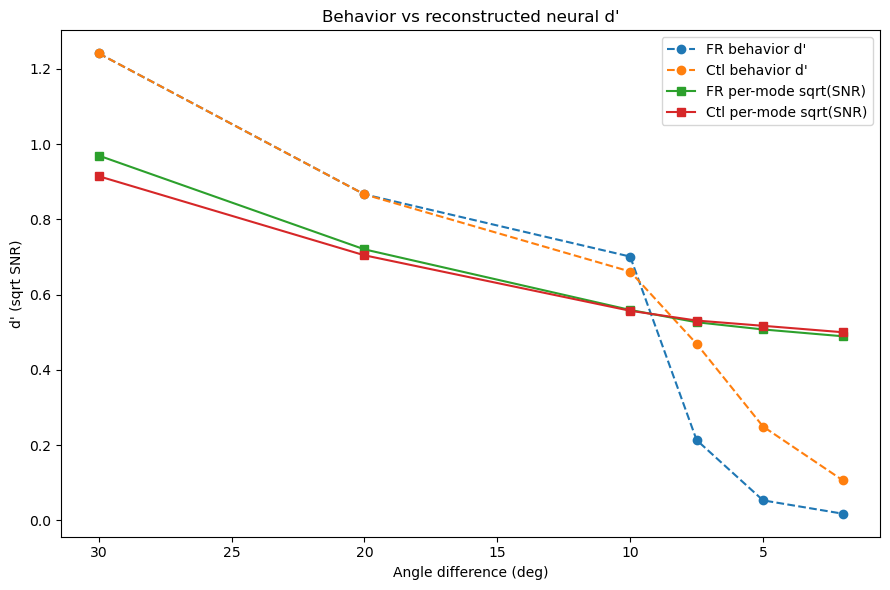

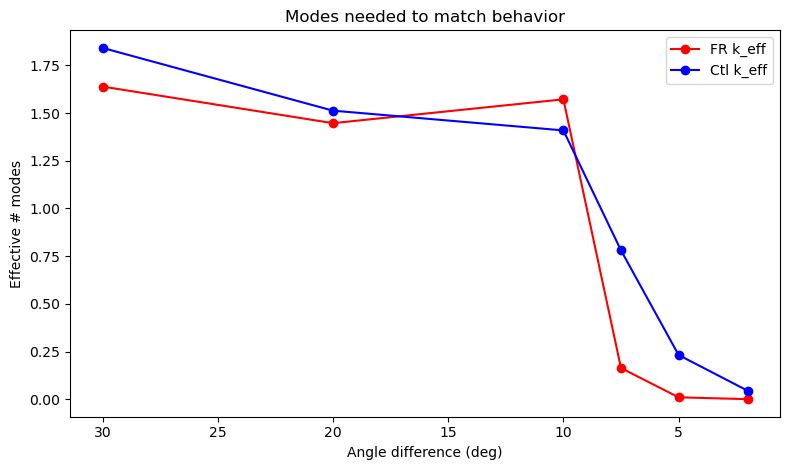

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d
data = np.load('snr_results_sated_full_6_compare.npz')
snr_fr = data['snr_outputs_mean_fr_full']
snr_ctr = data['snr_outputs_mean_ctr_full']


# -----------------------
# 1) Inputs (update these)
# -----------------------
x_behav = np.array([30, 20, 10, 7.5, 5, 2], dtype=float)

# Behavior (% correct) at those angles
fr_behaviour = np.array([.81, .73, .69, .56, .515, .505], dtype=float)   # example last point ~just above chance
ctr_behaviour = np.array([.81, .73, .68, .63, .57, .53], dtype=float)

# Neural per-mode SNR (= SNR/N) at those **same** angles
# Replace these with your arrays (shape must match x_behav)


plot_ctr =np.nanmean(snr_ctr, axis=1)
plot_fr = np.nanmean(snr_fr, axis=1)
fr_full_mean = np.nanmean(plot_fr, axis=0)
ctr_full_mean = np.nanmean(plot_ctr, axis=0)

fr_perm_at_angles = np.asarray(fr_full_mean, dtype=float)   # FR SNR/N at 30,20,10,7.5,5,2
ctr_perm_at_angles = np.asarray(ctr_full_mean, dtype=float) # Ctl SNR/N at 30,20,10,7.5,5,2

# If your neural data are on a different grid, set these instead:
# angles_lda = 360/conditions_array.astype(float)
# fr_perm_at_angles = interp1d(angles_lda, fr_full_mean, kind='linear', fill_value='extrapolate')(x_behav)
# ctr_perm_at_angles = interp1d(angles_lda, ctr_full_mean, kind='linear', fill_value='extrapolate')(x_behav)

# -----------------------
# 2) Behavior -> SNR (d'^2)
# -----------------------
clip = (1e-4, 1-1e-4)  # avoid infinities
fr_dprime = np.sqrt(2.0) * norm.ppf(np.clip(fr_behaviour, *clip))
ctr_dprime = np.sqrt(2.0) * norm.ppf(np.clip(ctr_behaviour, *clip))
fr_snr_behav = fr_dprime**2
ctr_snr_behav = ctr_dprime**2

# -----------------------
# 3) Effective # of modes
#     (your data are SNR/N already, so N_modes=1)
# -----------------------
fr_k_eff = fr_snr_behav / fr_perm_at_angles
ctr_k_eff = ctr_snr_behav / ctr_perm_at_angles
fr_k_eff_int = np.maximum(1, np.round(fr_k_eff)).astype(int)
ctr_k_eff_int = np.maximum(1, np.round(ctr_k_eff)).astype(int)

# -----------------------
# 4) Reconstruct d' from neural using k_eff
# -----------------------
fr_dprime_recon_frac = np.sqrt(fr_k_eff * fr_perm_at_angles)
ctr_dprime_recon_frac = np.sqrt(ctr_k_eff * ctr_perm_at_angles)
fr_dprime_recon_int = np.sqrt(fr_k_eff_int * fr_perm_at_angles)
ctr_dprime_recon_int = np.sqrt(ctr_k_eff_int * ctr_perm_at_angles)

# -----------------------
# 5) Plots
# -----------------------
plt.figure(figsize=(9,6))
plt.plot(x_behav, fr_dprime, 'o--', label="FR behavior d'")
plt.plot(x_behav, ctr_dprime, 'o--', label="Ctl behavior d'")
plt.plot(x_behav, np.sqrt(fr_perm_at_angles), 's-', label='FR per-mode sqrt(SNR)')
plt.plot(x_behav, np.sqrt(ctr_perm_at_angles), 's-', label='Ctl per-mode sqrt(SNR)')
# plt.plot(x_behav, fr_dprime_recon_frac, '^-', label="FR recon (fractional k_eff)")
# plt.plot(x_behav, ctr_dprime_recon_frac, '^-', label="Ctl recon (fractional k_eff)")
# plt.plot(x_behav, fr_dprime_recon_int, 'x--', label='FR recon (integer k)')
# plt.plot(x_behav, ctr_dprime_recon_int, 'x--', label='Ctl recon (integer k)')
plt.gca().invert_xaxis()  # optional: show fine angles on the right
plt.xlabel('Angle difference (deg)')
plt.ylabel("d' (sqrt SNR)")
plt.title("Behavior vs reconstructed neural d'")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4.8))
plt.plot(x_behav, fr_k_eff, 'o-', label='FR k_eff', color = 'red')
plt.plot(x_behav, ctr_k_eff, 'o-', label='Ctl k_eff', color = 'blue')
# plt.plot(x_behav, fr_k_eff_int, 'x--', label='FR k_eff (int)')
# plt.plot(x_behav, ctr_k_eff_int, 'x--', label='Ctl k_eff (int)')
plt.gca().invert_xaxis()  # optional
plt.xlabel('Angle difference (deg)')
plt.ylabel('Effective # modes')
plt.title('Modes needed to match behavior')
plt.legend()
plt.tight_layout()
plt.show()



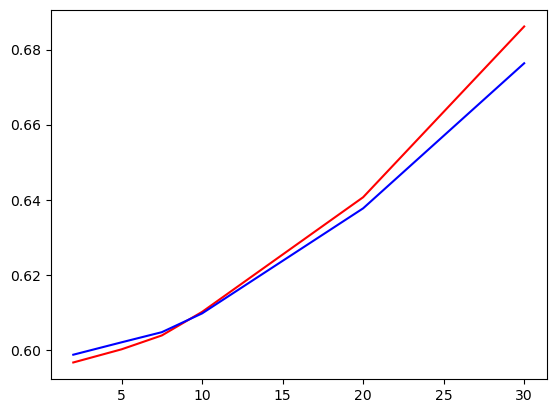

In [28]:
performance_from_lda_fr = norm.cdf(np.sqrt(fr_full_mean)/2)
performance_from_lda_ctr = norm.cdf(np.sqrt(ctr_full_mean)/2)
plt.plot(x_behav, performance_from_lda_fr, color = 'red')
plt.plot(x_behav, performance_from_lda_ctr, color = 'blue')


/tmp/ipykernel_539687/559522819.py:63: RuntimeWarning: Mean of empty slice
  plt.plot(360/np.array(conditions_saved), np.nanmean(best_k_array_fr, axis=(0,1)))
/tmp/ipykernel_539687/559522819.py:64: RuntimeWarning: Mean of empty slice
  plt.plot(360/np.array(conditions_saved), np.nanmean(best_k_array_ctr, axis=(0,1)))


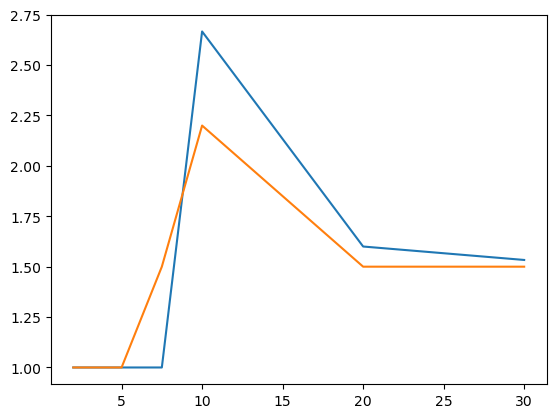

In [ ]:
import pickle
from pathlib import Path
def load_overlap_eigs(save_dir, group_prefix, animal, sf):
    """
    group_prefix: 'FR' or 'CTR' (or whatever you used as fname_prefix)
    sf: int or None
    """
    sf_tag = "best_sf" if sf is None else f"sf{int(sf)}"
    p = Path(save_dir) / f"{group_prefix}_{animal}_{sf_tag}_overlaps_eigs.pkl"
    with open(p, "rb") as f:
        return pickle.load(f)

# Example:
best_k_array_fr = np.full((8,5,7),np.nan)
for animal_number in range(1,9):
    for sf in range(5):
        try:
            data = load_overlap_eigs("saved_overlap_eigs", "FR", f"{animal_number}", sf=sf)
            overlaps_list = data["overlaps_per_condition"]  # list of arrays
            eigs_list = data["eigs_per_condition"]          # list of arrays
            for conds in range(len(overlaps_list)):
                snr_list = overlaps_list[conds] / eigs_list[conds]
                mean_snr = np.nanmean(snr_list, axis=(0))
                # select only certain modes s.t. mean_snr matches behaviour
                difference = []
                for k in range(1,30):
                    snr = mean_snr[:k]
                    total_snr = np.nansum(snr)
                    difference.append(np.abs(total_snr - fr_snr_behav[conds]))
                best_k = np.nanargmin(difference) + 1
                best_k_array_fr[animal_number-1, sf, conds] = best_k
        except Exception as e:
            continue


best_k_array_ctr = np.full((6,5,7),np.nan)
for animal_number in range(1,7):
    for sf in range(5):
        try:
            data = load_overlap_eigs("saved_overlap_eigs", "CTR", f"{animal_number}", sf=sf)
            overlaps_list = data["overlaps_per_condition"]  # list of arrays
            eigs_list = data["eigs_per_condition"]          # list of arrays
            for conds in range(len(overlaps_list)):
                snr_list = overlaps_list[conds] / eigs_list[conds]
                mean_snr = np.nanmean(snr_list, axis=(0))
                # select only certain modes s.t. mean_snr matches behaviour
                difference = []
                for k in range(1,30):
                    snr = mean_snr[:k]
                    total_snr = np.nansum(snr)
                    difference.append(np.abs(total_snr - ctr_snr_behav[conds]))
                best_k = np.nanargmin(difference) + 1
                best_k_array_ctr[animal_number-1, sf, conds] = best_k
        except Exception as e:
            continue
      
conditions_saved = [12, 18, 36, 48, 72, 180,360]
plt.plot(360/np.array(conditions_saved), np.nanmean(best_k_array_fr, axis=(0,1)))
plt.plot(360/np.array(conditions_saved), np.nanmean(best_k_array_ctr, axis=(0,1)))


/tmp/ipykernel_539687/637479198.py:192: RuntimeWarning: Mean of empty slice
  mean_fr = np.nanmean(arr_fr, axis=(0,1))
/tmp/ipykernel_539687/637479198.py:194: RuntimeWarning: Mean of empty slice
  mean_ctr = np.nanmean(arr_ctr, axis=(0,1))
/tmp/ipykernel_539687/637479198.py:232: RuntimeWarning: Mean of empty slice
  mean_eps_fr  = np.nanmean(eps_array_fr, axis=(0,1))
/tmp/ipykernel_539687/637479198.py:234: RuntimeWarning: Mean of empty slice
  mean_eps_ctr = np.nanmean(eps_array_ctr, axis=(0,1))


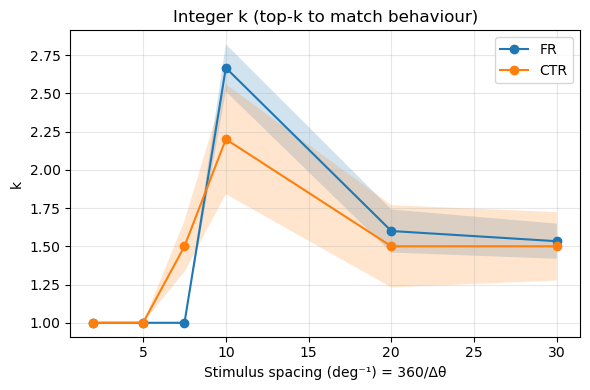

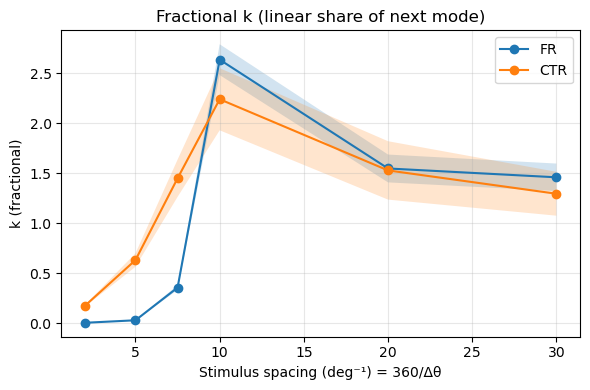

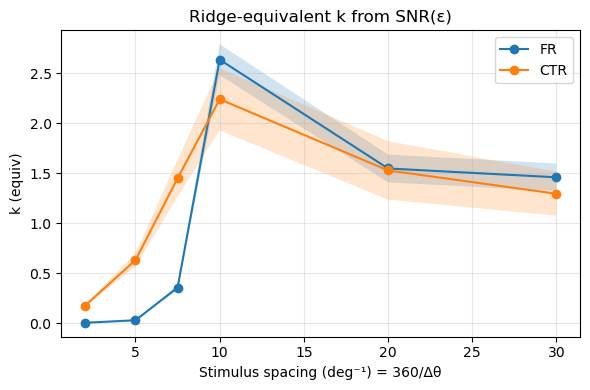

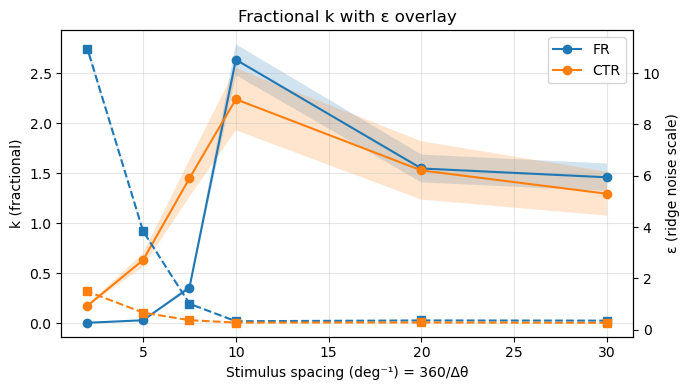

In [57]:
import numpy as np
from math import isfinite

def clean_vec(x):
    """Replace negatives with 0 and NaNs with 0 (SNR contributions should be ≥0)."""
    x = np.asarray(x, float)
    x = np.where(np.isfinite(x), x, 0.0)
    x = np.where(x > 0, x, 0.0)
    return x

def fractional_k_from_snr(mean_snr, target_snr):
    """
    mean_snr: 1D array of per-mode SNR contributions s_i (e.g., overlap_i / lambda_i).
              Use them in the SAME order you want to ‘add’ modes (your current order).
    target_snr: scalar (behavioural SNR to match).
    
    Returns:
      k_frac: fractional number of modes needed
      achieved: the SNR we actually match (clipped if target > total)
      idx: the (integer) last full mode used (0-based); the fractional part is on idx
      alpha: fraction of the (idx)-th mode used in [0,1]
    """
    s = clean_vec(mean_snr)
    if s.size == 0:
        return np.nan, 0.0, -1, 0.0

    c = np.cumsum(s)
    total = c[-1]
    # If target is larger than everything you have, return full k
    if target_snr >= total:
        return float(len(s)), total, len(s)-1, 1.0
    if target_snr <= 0:
        return 0.0, 0.0, -1, 0.0

    # Find first index where cumsum >= target
    m = int(np.searchsorted(c, target_snr, side='left'))
    # Use m-1 full modes + fractional of m-th mode
    prev_sum = 0.0 if m == 0 else c[m-1]
    need = target_snr - prev_sum
    denom = s[m] if s[m] > 0 else np.finfo(float).eps
    alpha = np.clip(need / denom, 0.0, 1.0)
    k_frac = (m) + alpha  # because m full modes (0..m-1) + alpha of mode m

    achieved = prev_sum + alpha * s[m]
    return float(k_frac), float(achieved), m, float(alpha)

def snr_with_ridge(overlaps, lambdas, eps):
    """
    overlaps: 1D array with overlap_i = |v_i^T Δμ|^2  (or your per-mode numerator)
    lambdas: 1D array of noise eigenvalues λ_i
    eps: nonnegative scalar (ridge)
    Returns scalar SNR(eps) = sum overlap_i / (λ_i + eps^2).
    """
    ov = clean_vec(overlaps)
    la = np.asarray(lambdas, float)
    la = np.where(np.isfinite(la) & (la > 0), la, np.nan)  # guard bad λ
    denom = la + eps**2
    denom = np.where(np.isfinite(denom) & (denom > 0), denom, np.nan)
    term = ov / denom
    return np.nansum(term)

def fit_eps_for_target(overlaps, lambdas, target_snr, tol=1e-6, max_iter=100):
    """
    Find eps >= 0 such that snr_with_ridge(overlaps,lambdas,eps) ≈ target_snr.
    Monotone decreasing in eps. Uses bracket + bisection. Returns (eps, snr_eps).
    If target is larger than SNR(0), returns eps=0. If target ≤ ~0, returns large eps.
    """
    # Evaluate bounds
    s0 = snr_with_ridge(overlaps, lambdas, 0.0)
    if not isfinite(s0) or s0 <= 0:
        return np.nan, 0.0  # ill-posed
    if target_snr >= s0:
        return 0.0, s0
    if target_snr <= 0:
        # pick an eps so large that SNR ~ 0
        return 1e6, snr_with_ridge(overlaps, lambdas, 1e6)

    # Find a high eps with SNR below target
    lo, hi = 0.0, 1.0
    shi = snr_with_ridge(overlaps, lambdas, hi)
    it_guard = 0
    while shi > target_snr and it_guard < 60:
        hi *= 2.0
        shi = snr_with_ridge(overlaps, lambdas, hi)
        it_guard += 1
    # Bisection
    slo = s0
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        smid = snr_with_ridge(overlaps, lambdas, mid)
        if abs(smid - target_snr) <= tol:
            return mid, smid
        if smid > target_snr:
            lo, slo = mid, smid
        else:
            hi, shi = mid, smid
    # Return best bracket endpoint
    if abs(slo - target_snr) < abs(shi - target_snr):
        return lo, slo
    else:
        return hi, shi
# --- FR ---
k_frac_array_fr       = np.full((8,5,7), np.nan)
eps_array_fr          = np.full((8,5,7), np.nan)
snr_ridge_array_fr    = np.full((8,5,7), np.nan)
k_equiv_ridge_fr      = np.full((8,5,7), np.nan)  # optional: map SNR(eps) to fractional-k via cumulative curve

for animal_number in range(1,9):
    for sf in range(5):
        try:
            data = load_overlap_eigs("saved_overlap_eigs", "FR", f"{animal_number}", sf=sf)
            overlaps_list = data["overlaps_per_condition"]  # list of arrays
            eigs_list = data["eigs_per_condition"]          # list of arrays
            for conds in range(len(overlaps_list)):
                # Shape assumptions: arrays where last axis = modes (K)
                # Your code uses mean over axis=(0); keep consistent:
                snr_list = overlaps_list[conds] / eigs_list[conds]      # array (..., K)
                mean_snr = np.nanmean(snr_list, axis=0)                 # (K,)
                # --- fractional k ---
                kf, achieved, idx, alpha = fractional_k_from_snr(mean_snr, fr_snr_behav[conds])
                k_frac_array_fr[animal_number-1, sf, conds] = kf

                # --- ridge / PCA-denoising fit ---
                # Per-mode overlaps and lambdas for ridge (use the SAME averaging as above):
                overlaps_mean = np.nanmean(overlaps_list[conds], axis=0)  # (K,)
                lambdas_mean  = np.nanmean(eigs_list[conds],     axis=0)  # (K,)

                eps, snr_eps = fit_eps_for_target(overlaps_mean, lambdas_mean, fr_snr_behav[conds], tol=1e-6)
                eps_array_fr[animal_number-1, sf, conds] = eps
                snr_ridge_array_fr[animal_number-1, sf, conds] = snr_eps

                # Optionally: convert SNR(eps) to an "equivalent fractional k"
                kf2, _, _, _ = fractional_k_from_snr(mean_snr, snr_eps)
                k_equiv_ridge_fr[animal_number-1, sf, conds] = kf2

        except Exception:
            continue

# --- CTR ---
k_frac_array_ctr       = np.full((6,5,7), np.nan)
eps_array_ctr          = np.full((6,5,7), np.nan)
snr_ridge_array_ctr    = np.full((6,5,7), np.nan)
k_equiv_ridge_ctr      = np.full((6,5,7), np.nan)

for animal_number in range(1,7):
    for sf in range(5):
        try:
            data = load_overlap_eigs("saved_overlap_eigs", "CTR", f"{animal_number}", sf=sf)
            overlaps_list = data["overlaps_per_condition"]  # list of arrays
            eigs_list = data["eigs_per_condition"]          # list of arrays
            for conds in range(len(overlaps_list)):
                snr_list = overlaps_list[conds] / eigs_list[conds]
                mean_snr = np.nanmean(snr_list, axis=0)

                kf, achieved, idx, alpha = fractional_k_from_snr(mean_snr, ctr_snr_behav[conds])
                k_frac_array_ctr[animal_number-1, sf, conds] = kf

                overlaps_mean = np.nanmean(overlaps_list[conds], axis=0)
                lambdas_mean  = np.nanmean(eigs_list[conds],     axis=0)

                eps, snr_eps = fit_eps_for_target(overlaps_mean, lambdas_mean, ctr_snr_behav[conds], tol=1e-6)
                eps_array_ctr[animal_number-1, sf, conds] = eps
                snr_ridge_array_ctr[animal_number-1, sf, conds] = snr_eps

                kf2, _, _, _ = fractional_k_from_snr(mean_snr, snr_eps)
                k_equiv_ridge_ctr[animal_number-1, sf, conds] = kf2

        except Exception:
            continue


import numpy as np
import matplotlib.pyplot as plt

conditions_saved = [12, 18, 36, 48, 72, 180, 360]
x = 360/np.array(conditions_saved)  # matches your original

def nansem(a, axis=None):
    a = np.array(a, float)
    n = np.sum(np.isfinite(a), axis=axis)
    sd = np.nanstd(a, axis=axis, ddof=1)
    return sd / np.sqrt(np.maximum(n, 1))

def plot_fr_ctr(arr_fr, arr_ctr, x, title, ylabel, ax=None):
    """
    arr_* shape: (n_animals, n_sfs, n_conditions)
    x shape: (n_conditions,)
    """
    if ax is None:
        ax = plt.gca()

    mean_fr = np.nanmean(arr_fr, axis=(0,1))
    sem_fr  = nansem(arr_fr, axis=(0,1))
    mean_ctr = np.nanmean(arr_ctr, axis=(0,1))
    sem_ctr  = nansem(arr_ctr, axis=(0,1))

    # FR
    ax.plot(x, mean_fr, label='FR', marker='o')
    ax.fill_between(x, mean_fr - sem_fr, mean_fr + sem_fr, alpha=0.2)

    # CTR
    ax.plot(x, mean_ctr, label='CTR', marker='o')
    ax.fill_between(x, mean_ctr - sem_ctr, mean_ctr + sem_ctr, alpha=0.2)

    ax.set_xlabel('Stimulus spacing (deg⁻¹) = 360/Δθ')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    return ax

# 1) Your original integer-k plot (but with shaded SEM)
plt.figure(figsize=(6,4))
plot_fr_ctr(best_k_array_fr, best_k_array_ctr, x, title='Integer k (top-k to match behaviour)', ylabel='k')
plt.tight_layout()

# 2) Fractional-k plot
plt.figure(figsize=(6,4))
plot_fr_ctr(k_frac_array_fr, k_frac_array_ctr, x, title='Fractional k (linear share of next mode)', ylabel='k (fractional)')
plt.tight_layout()

# 3) Ridge-equivalent k (map SNR(ε) onto cumulative curve)
plt.figure(figsize=(6,4))
plot_fr_ctr(k_equiv_ridge_fr, k_equiv_ridge_ctr, x, title='Ridge-equivalent k from SNR(ε)', ylabel='k (equiv)')
plt.tight_layout()

# 4) (Optional) ε itself on a right y-axis, alongside, say, fractional k
fig, ax = plt.subplots(figsize=(7,4))
plot_fr_ctr(k_frac_array_fr, k_frac_array_ctr, x, title='Fractional k with ε overlay', ylabel='k (fractional)', ax=ax)

ax2 = ax.twinx()
mean_eps_fr  = np.nanmean(eps_array_fr, axis=(0,1))
sem_eps_fr   = nansem(eps_array_fr, axis=(0,1))
mean_eps_ctr = np.nanmean(eps_array_ctr, axis=(0,1))
sem_eps_ctr  = nansem(eps_array_ctr, axis=(0,1))

# plot ε with dashed lines on the twin axis
ax2.plot(x, mean_eps_fr,  linestyle='--', marker='s')
ax2.fill_between(x, mean_eps_fr - sem_eps_fr, mean_eps_fr + sem_eps_fr, alpha=0.15)
ax2.plot(x, mean_eps_ctr, linestyle='--', marker='s')
# ax2.fill_between(x, mean_eps_ctr - sem_eps_ctr, alpha=0.15, y1=mean_eps_ctr - sem_eps_ctr, y2=mean_eps_ctr + sem_eps_ctr)

ax2.set_ylabel('ε (ridge noise scale)')
fig.tight_layout()


Text(0, 0.5, 'SNR (80 random neurons)')

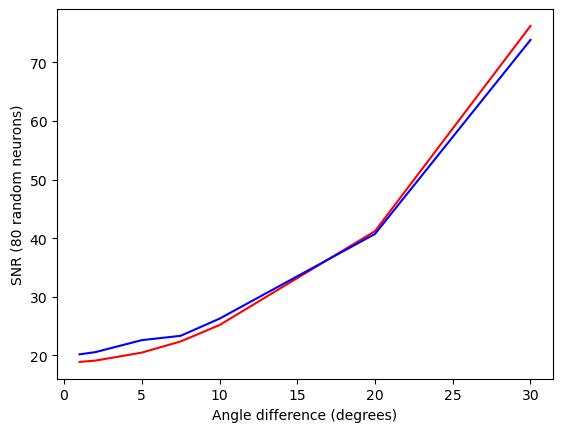

In [63]:
# Example:
sum_snr_value_fr = np.full((8,5,7),np.nan)
for animal_number in range(1,9):
    for sf in range(5):
        try:
            data = load_overlap_eigs("saved_overlap_eigs", "FR", f"{animal_number}", sf=sf)
            overlaps_list = data["overlaps_per_condition"]  # list of arrays
            eigs_list = data["eigs_per_condition"]          # list of arrays
            for conds in range(len(overlaps_list)):
                random_sample_80_neurons = np.random.choice(overlaps_list[conds].shape[1], size=80, replace=False)

                snr_list = overlaps_list[conds] / eigs_list[conds]

                mean_snr = np.nanmean(snr_list, axis=(0))
                random_sample_80_neurons_snr = mean_snr[random_sample_80_neurons]
                total_snr = np.nansum(random_sample_80_neurons_snr)
                sum_snr_value_fr[animal_number-1, sf, conds] = total_snr
        except Exception as e:
            continue


sum_snr_value_ctr = np.full((6,5,7),np.nan)
for animal_number in range(1,7):
    for sf in range(5):
        try:
            data = load_overlap_eigs("saved_overlap_eigs", "CTR", f"{animal_number}", sf=sf)
            overlaps_list = data["overlaps_per_condition"]  # list of arrays
            eigs_list = data["eigs_per_condition"]          # list of arrays
            for conds in range(len(overlaps_list)):
                random_sample_80_neurons = np.random.choice(overlaps_list[conds].shape[1], size=80, replace=False)
                snr_list = overlaps_list[conds] / eigs_list[conds]
                mean_snr = np.nanmean(snr_list, axis=(0))
                random_sample_80_neurons_snr = mean_snr[random_sample_80_neurons]
                total_snr = np.nansum(random_sample_80_neurons_snr)
                sum_snr_value_ctr[animal_number-1, sf, conds] = total_snr
        except Exception as e:
            continue
      
conditions_saved = [12, 18, 36, 48, 72, 180,360]
plt.plot(360/np.array(conditions_saved), np.nanmean(sum_snr_value_fr, axis=(0,1)), color = 'red')
plt.plot(360/np.array(conditions_saved), np.nanmean(sum_snr_value_ctr, axis=(0,1)), color = 'blue')
plt.xlabel('Angle difference (degrees)')
plt.ylabel('SNR (80 random neurons)')